In [1]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

In [2]:
from pathlib import Path
from datetime import datetime, timedelta, timezone
from math import factorial
import itertools
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullLocator, FixedLocator
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
from skimage.io import imread

In [277]:
from lropy.analysis.io import load_pickled_simulation_results
from lropy.analysis.io import pos_names, vel_names, acc_names, irr_names, panels_count_names
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.util import get_revolutions_index, get_day_index, trim_df, get_closest_before, get_closest_after, trim_df_revolutions, rmse, rrmse
from lropy.analysis.transform import cart2spher, spher2cart, align_vectors
from lropy.analysis.spice_tools import get_distance, get_lro_beta_angle, as_et
from lropy.constants import JULIAN_DAY, moon_radius, earth_equatorial_radius, c, lro_period, astronomical_unit
from lropy.analysis.maps import moon_globe

In [4]:
def get_orbit_start(n_orbit):
    # 83 min to start opposite of subsolar point
    return pd.to_datetime(datetime(2010, 9, 26, 6) + timedelta(minutes=n_orbit*113) + timedelta(minutes=83), utc=True)

In [5]:
def get_orbit_number(time):
    time -= get_orbit_start(0)
    return (time.days * JULIAN_DAY + time.seconds) / lro_period

In [6]:
orbit_steps = int(lro_period / 5)
variable_columns = [
    "simulation_start", "use_solar_radiation", "use_moon_radiation", "target_type", "albedo_distribution_moon", "use_occultation"
]

plots_folder = "../paper/figures/plots"
tables_folder = "../paper/tables"

# Orbit geometry

Sun: 6.076454727187199e-08
Moon: 2.2923204712007033e-08


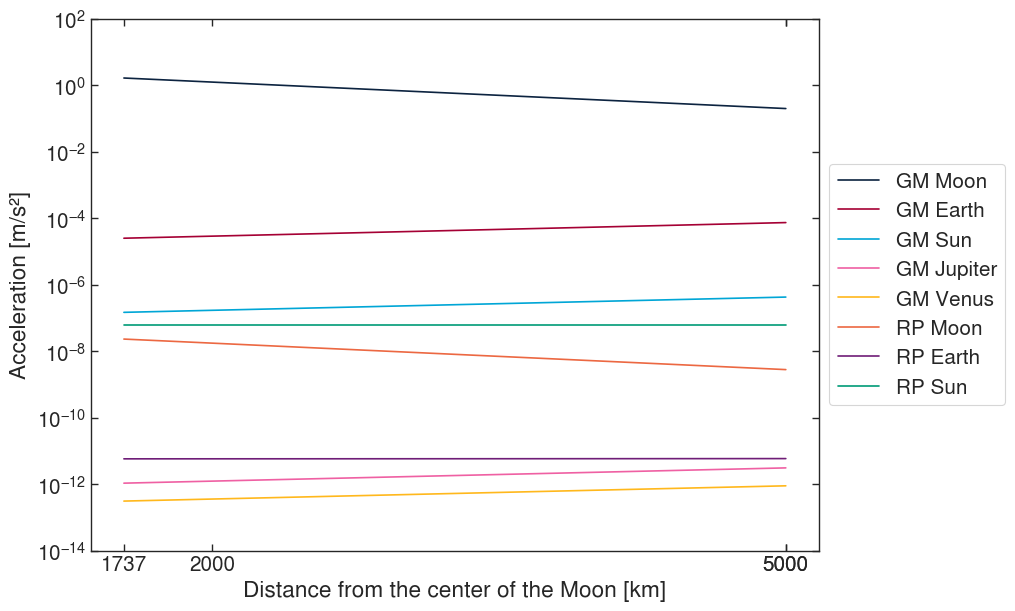

In [7]:
def plot_all_accelerations_magnitude():
    def grav_central(body, r, r_moon=None):
        gm = {
            "earth": 0.39860e6,
            "sun": 132712e6,
            "moon": 0.00490e6,
            "jupiter": 126.687e6,
            "venus": 0.32486e6
        }[body]  # km^3/s^2
    
        if body == "moon":
            # Regular central gravity
            return  gm / r**2 * 1e3
        else:
            # Perturbation
            return 2 * gm * r_moon / r**3 * 1e3
    
    # def grav_higher_order(n, m, r):
    #     def normalization_coeff(n, m):
    #         delta = 1 if m == 0 else 0
    #         return np.sqrt(factorial(n + m) / ((2 - delta) * (2*n + 1) * factorial(n - m)))
        
    #     J = {
    #         (2, 0): 9.088,
    #         (2, 2): 3.467e-5 + 9.079e-10,
    #     }[(n, m)] / normalization_coeff(n, m)
    #     return 0.00490e9 * 1738 ** n / r ** (n+2) * J

    def rp(body, r):
        A_m_Cp = 14.0 / 1087 * 1.0  # m^2/kg
        sun_luminosity = 3.828e26  # W

        if body == "sun":
            solar_irradiance = sun_luminosity / (4 * np.pi * r**2) / 1e6
            return A_m_Cp * solar_irradiance / c
        elif body == "moon":
            solar_irradiance = sun_luminosity / (4 * np.pi * r_moon_sun**2) / 1e6
            acc_rp_sun = A_m_Cp * solar_irradiance / c
            albedo = 0.15 / 2 * (moon_radius/1e3 / r)**2 * acc_rp_sun
            moon_thermal_irr = 900  # somewhat arbitrary average from Lemoine 2013, but order of magnitude not very sensitive to exact value
            thermal = 0.95 / 2 * A_m_Cp * moon_thermal_irr / c * (moon_radius/1e3 / r)**2
            return albedo + thermal
        elif body == "earth":
            solar_irradiance = sun_luminosity / (4 * np.pi * r_earth_sun**2) / 1e6
            acc_rp_sun = A_m_Cp * solar_irradiance / c
            return (0.34 / 2 + 0.68 / 4) * (earth_equatorial_radius/1e3 / r)**2 * acc_rp_sun
    
    r_moon_earth = 384400
    r_moon_sun = 146757375
    r_moon_jupiter = 744857858
    r_moon_venus = 154196622
    r_earth_sun = r_moon_sun

    rr_moon = np.linspace(moon_radius / 1e3, 5e3, 20)  # km
    rr_earth = r_moon_earth - rr_moon
    rr_sun = r_moon_sun -rr_moon
    rr_jupiter = r_moon_jupiter - rr_moon
    rr_venus = r_moon_venus - rr_moon

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(rr_moon, grav_central("moon", rr_moon), label="GM Moon")
    ax.plot(rr_moon, grav_central("earth", rr_earth, rr_moon), label="GM Earth")
    ax.plot(rr_moon, grav_central("sun", rr_sun, rr_moon), label="GM Sun")
    ax.plot(rr_moon, grav_central("jupiter", rr_jupiter, rr_moon), label="GM Jupiter")
    ax.plot(rr_moon, grav_central("venus", rr_venus, rr_moon), label="GM Venus")

    ax.plot(rr_moon, rp("moon", rr_moon), label="RP Moon")
    ax.plot(rr_moon, rp("earth", rr_earth), label="RP Earth")
    ax.plot(rr_moon, rp("sun", rr_sun), label="RP Sun")
    print("Sun:", rp("sun", rr_sun)[0])
    print("Moon:", rp("moon", rr_moon)[0])

    ax.set_xlabel("Distance from the center of the Moon [km]")
    ax.set_ylabel("Acceleration [m/s²]")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim([1e-14, 1e2])
    # ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    format_plot(x_major_locator=FixedLocator([rr_moon[0], 2e3, 5e3, rr_moon[-1]]), x_minor_locator=NullLocator())
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plot_all_accelerations_magnitude()

Want to only consider accelerations much larger than RP which significantly determine orbit over 2.5 day arc.

# Lunar models

In [8]:
def tf_mosaic(dist):
    dist = dist.astype(np.double)
    dist -= 1
    dist /= 255
    dist = dist * (0.5 - 0.048) + 0.048
    return dist

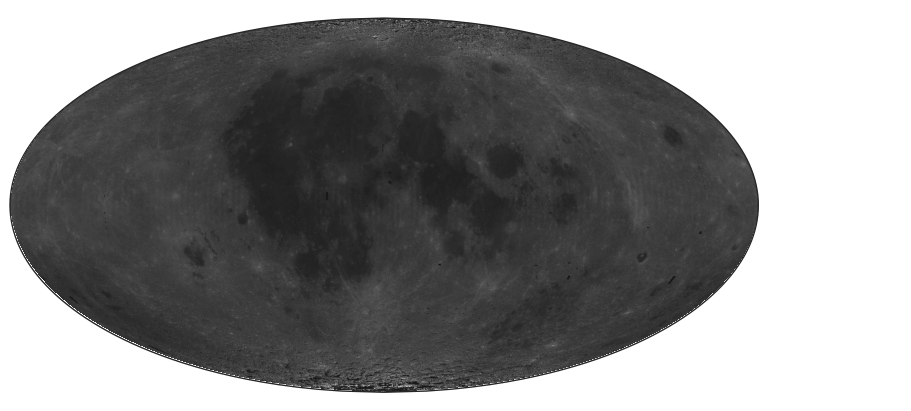

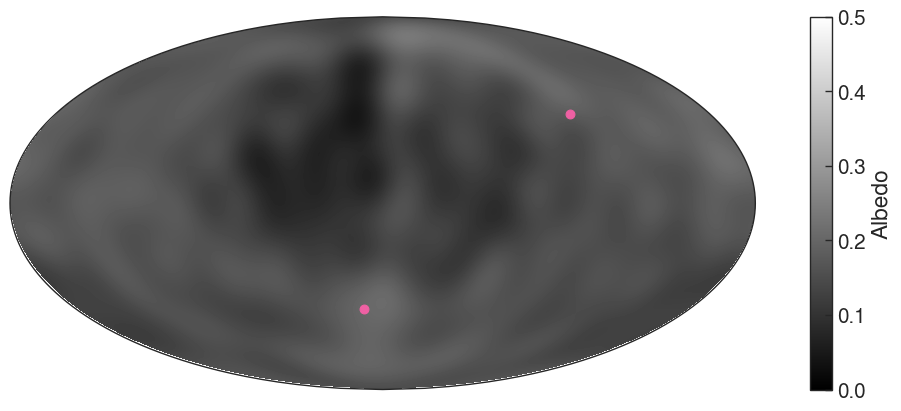

In [528]:
def plot_albedo_map():
    fig = plt.figure(figsize=(9, 4), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[7, 0.92], wspace=0.1) 
    ax = fig.add_subplot(gs[0], projection=ccrs.Mollweide(globe=moon_globe))
    cax = fig.add_subplot(gs[1])
    dist = tf_mosaic(imread("files/albedo.jpg"))
    
    ax.imshow(dist, transform=ccrs.PlateCarree(globe=moon_globe), extent=(-180, 180, -90, 90), cmap="gray", vmin=0, vmax=0.5)
    # ax.gridlines(draw_labels=["bottom", "left"], crs=ccrs.PlateCarree(globe=moon_globe))
    cax.set_axis_off()
    save_plot(plots_folder, "lunar_map_photo")

    fig = plt.figure(figsize=(9, 4), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[7, 0.2], wspace=0.1) 
    ax = fig.add_subplot(gs[0], projection=ccrs.Mollweide(globe=moon_globe))
    cax = fig.add_subplot(gs[1])
    dist = np.load("../private/dlam1.npy")
    im = ax.imshow(dist, transform=ccrs.PlateCarree(globe=moon_globe), extent=(-180, 180, -90, 90), cmap="gray", vmin=0, vmax=0.5)
    fig.colorbar(im, cax=cax, label="Albedo", use_gridspec=True)
    ax.scatter([-11, 103], [-43, 36], marker="o", c="C3", s=40, transform=ccrs.PlateCarree(globe=moon_globe))
    save_plot(plots_folder, "lunar_map_dlam1")
    
plot_albedo_map()

0.04622745098039216 0.4982274509803922 0.1208333306632689 0.11890196078431373 0.2890666666666667
0.043116665357974475 0.23649248438719175 0.15361859395452387 0.15550402250567819 0.21763279392080914


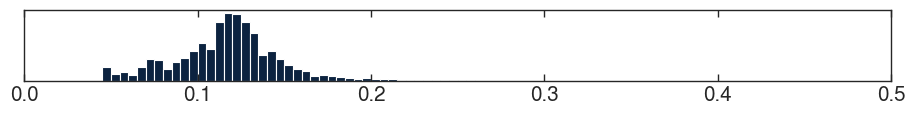

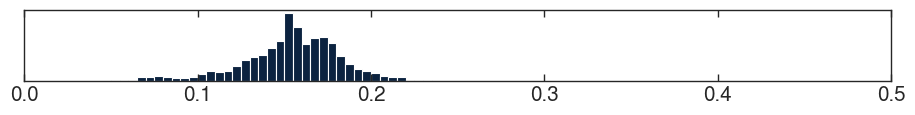

In [10]:
def plot_albedo_histogram(dist, file):
    fig, ax = plt.subplots(figsize=(9, 1))

    print(dist.min(), dist.max(), dist.mean(), np.median(dist), np.percentile(dist, 99))

    ax.hist(dist.flatten(), bins=100, density=True, range=[0, 0.5])
    # ax.set_xlabel("Albedo")
    ax.set_xlim([0, 0.5])
    ax.get_yaxis().set_visible(False)

    format_plot()
    save_plot(plots_folder, file)
    
plot_albedo_histogram(tf_mosaic(imread("files/albedo.jpg")), "lunar_hist_photo")
plot_albedo_histogram(np.load("../private/dlam1.npy"), "lunar_hist_dlam1")

0.1208333306632689


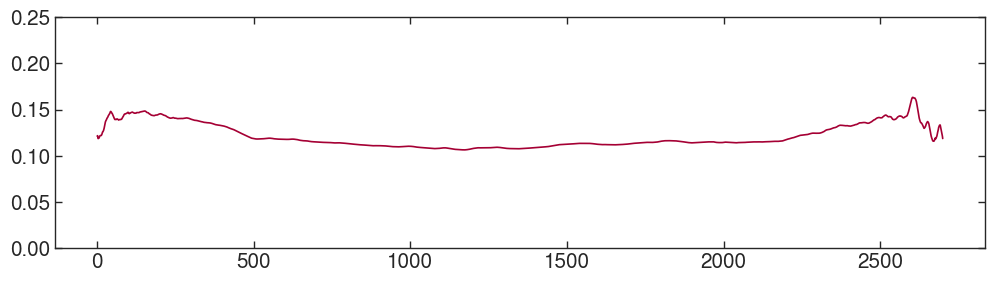

In [11]:
def plot_longitudinal_distribution():
    dist = tf_mosaic(imread("files/albedo.jpg"))

    # dist = dist[::5, ::5]
    # plt.scatter(list(range(dist.shape[0])) * dist.shape[1], dist.flatten(), s=1, alpha=0.1)

    print(np.mean(dist.flatten()))
    mean = dist.mean(axis=1)
    N = int(dist.shape[1] / 180)
    mean = np.convolve(mean, np.ones(N)/N, mode='valid')
    # mean = np.histogram(mean, np.arange(0, 180), weights=mean)[0] / np.histogram(mean, np.arange(0, 180), )[0]

    plt.plot(mean, c="C1")
    plt.ylim([0, 0.25])

plot_longitudinal_distribution()

5.670374419
1245.8181527278637


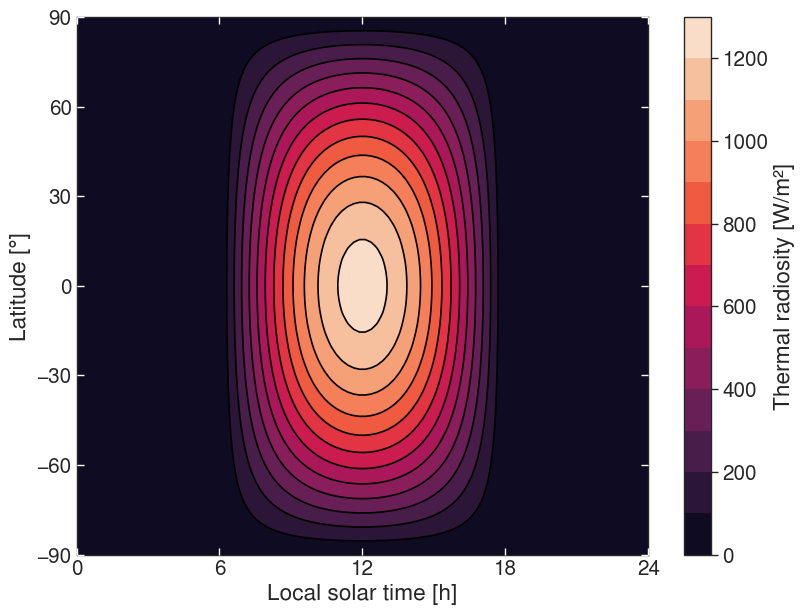

In [198]:
def thermal_radiation(polar, azimuth):
        subsolar = np.array([1, 0, 0])
        normal = np.array([
            np.cos(azimuth) * np.sin(polar),
            np.sin(azimuth) * np.sin(polar),
            np.cos(polar)
        ])
        cosphi = max(0, subsolar @ normal)
        
        sigma = 5.670374419e-8
        T = max(385 * cosphi**(1/4), 100)
        return sigma * T**4

def plot_thermal_lemoine():
    # Recreate Fig. 5 from Lemoine 2013
    polarlist = np.linspace(0, 1, 100) * np.pi
    azimuthlist = np.linspace(-1, 1, 100) * np.pi
    polars, azimuths = np.meshgrid(polarlist, azimuthlist)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    exitances = np.vectorize(thermal_radiation)(polars, azimuths)
    im = ax.contourf((azimuths / np.pi + 1) * 12, 90 - np.degrees(polars), exitances, levels=12)
    ax.contour((azimuths / np.pi + 1) * 12, 90 - np.degrees(polars), exitances, levels=12, colors="black")
    cb = fig.colorbar(im, ax=ax, label=r"Thermal radiosity [W/m²]")

    ax.set_xlabel("Local solar time [h]")
    ax.set_ylabel("Latitude [°]")
    ax.tick_params(color="white")

    cb.ax.yaxis.tick_right()
    cb.ax.tick_params(direction="out", which="both")

    format_plot(
        x_major_locator=FixedLocator([0, 6, 12, 18, 24]),
        y_major_locator=FixedLocator(range(-90, 91, 30)),
    )
    save_plot(plots_folder, "thermal_map")
    
plot_thermal_lemoine()
print(thermal_radiation(0, 0))
print(thermal_radiation(np.pi / 2, 0))

# Paneling

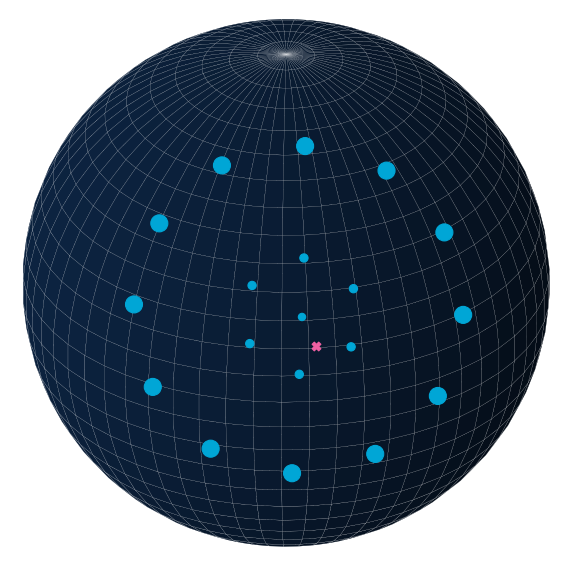

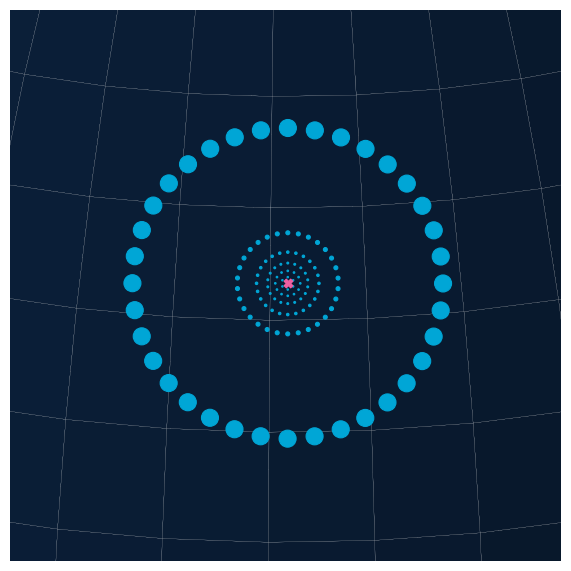

In [13]:
def calculate_cap_polar_angle(h, planet_radius):
    return np.arccos(planet_radius / (h + planet_radius))

def generate_panels_knocke(pos, n_panels_per_ring: list[int], R_e):
    # Initialize with central cap
    polars = [0]
    azimuths = [0]
    areas_from_geometry = []

    N = 1 + sum(n_panels_per_ring)

    r_s = np.linalg.norm(pos)

    zeta_m = np.arcsin(R_e / r_s)
    zeta_1 = np.arccos((N - 1 + np.cos(zeta_m)) / N)
    gamma_1 = np.arcsin(r_s * np.sin(zeta_1) / R_e)
    betas = [gamma_1 - zeta_1]

    area_central_cap = 2 * np.pi * R_e**2 * (1 - np.cos(betas[0]))
    areas_from_geometry.append(area_central_cap)

    k = 1
    for N_s in n_panels_per_ring:
        k += N_s
        zeta_i = np.arccos(k * np.cos(zeta_1) - k + 1)
        # gamma_i = np.arcsin(r_s * np.sin(zeta_i) / R_e)
        gamma_i = np.arcsin(min(1.0, r_s * np.sin(zeta_i) / R_e))
        betas.append(gamma_i - zeta_i)

        azimuths.extend(np.linspace(0, 2 * np.pi, N_s + 1)[:-1])

    for N_s, lower, upper in zip(n_panels_per_ring, betas[:-1], betas[1:]):
        beta_star = (lower + upper) / 2
        polars.extend([beta_star] * N_s)

        # Area from actual area on sphere
        areas_from_geometry.extend([2 * np.pi * R_e**2 * (np.cos(lower) - np.cos(upper)) / N_s] * N_s)

    assert len(polars) == len(areas_from_geometry)
    assert len(polars) == len(azimuths)
    assert len(polars) == sum(n_panels_per_ring) + 1

    rotation = align_vectors(np.array([0, 0, 1]), pos)
    polars_rotated = []
    azimuths_rotated = []

    for polar, azimuth in zip(polars, azimuths):
        coords_cartesian = spher2cart(R_e, polar, azimuth)
        # coords_cartesian_target_centric = rotation.apply(coords_cartesian)
        coords_cartesian_target_centric = rotation @ coords_cartesian
        coords_spherical_target_centric = cart2spher(*coords_cartesian_target_centric)
        polars_rotated.append(coords_spherical_target_centric[1] % (np.pi))
        azimuths_rotated.append(coords_spherical_target_centric[2] % (2 * np.pi))
    
    return polars_rotated, azimuths_rotated, np.array(areas_from_geometry)

def plot_dynamically_paneled_sphere(fig, ax, n_panels_per_ring: list[int], h, pos, zoom):
    pos = np.array(pos)

    radius = moon_radius / 1e3

    altitude = radius + h
    pos = pos / np.linalg.norm(pos) * altitude

    azimuths, polars = np.mgrid[0:2*np.pi:60j, 0:np.pi:30j]

    ax.plot_surface(*spher2cart(radius*0.99, polars, azimuths), alpha=1, linewidth=0.1, rasterized=True, rcount=1000, ccount=1000)
    
    panels = generate_panels_knocke(pos, n_panels_per_ring, radius)
    ax.scatter(*spher2cart(radius, *panels[:-1]), c="C2", label="panels", s=150 * panels[-1] / panels[-1].max(), depthshade=False)
    
    ax.scatter(*pos, marker="X", c="C3", s=40, label="spacecraft")

    # Nadir vector
    # ax.plot(*np.array([pos, pos / np.linalg.norm(pos) * radius]).T, c="white")

    # Draw circle of visible region
    cap_polar = calculate_cap_polar_angle(h, radius)
    rotation = align_vectors(np.array([0, 0, 1]), pos)
    visible_region = np.zeros((100, 3))

    for i, azimuth in enumerate(np.linspace(0, 2*np.pi, 100)):
        visible_region[i, :] = rotation @ np.array(spher2cart(radius, cap_polar, azimuth))
    ax.plot(*visible_region.T, c="C1", label="visible latitude")
    
    lim = radius * zoom
    ax.set_xlim([-lim*0.9, lim])
    ax.set_ylim([-lim, lim])
    ax.set_zlim([-lim, lim*1.1])
    ax.set_aspect("equal")

    ax.set_axis_off()

def plot_knocke_paneling():
    def get_ax():
        return plt.subplots(figsize=[12, 6], subplot_kw={"projection": "3d", "proj_type": "ortho"}, tight_layout=True)
    
    fig, ax = get_ax()
    plot_dynamically_paneled_sphere(fig, ax, [6, 12], 1500, [2, -3, 1.5], 0.59)
    save_plot(plots_folder, "knocke_paneling_high")

    fig, ax = get_ax()
    plot_dynamically_paneled_sphere(fig, ax, [6, 12, 18, 24, 30, 36], 50, [2, -3.45, 2.3], 0.15)
    save_plot(plots_folder, "knocke_paneling_low")

plot_knocke_paneling()

1 860.946595213065 48.96501109757034
2 1152.44759226277 31.68548385140334
3 1321.42796000686 21.668705527988408
4 1424.08959885205 15.583153150755436
5 1491.93102655021 11.561665024835454
6 1539.54192644153 8.739397347492606
7 1574.47699546323 6.6685245782160845
8 1601.0067984384 5.095897184194764
9 1616.54041694608 4.175099015572192
10 1638.70957029356 2.860961180129673
11 1652.31541645328 2.054437045380497
12 1663.33526032872 1.401205343185996
13 1672.52644534687 0.856372448777043
14 1680.30911991684 0.3950329040038336
15 1686.97321921447 0.0


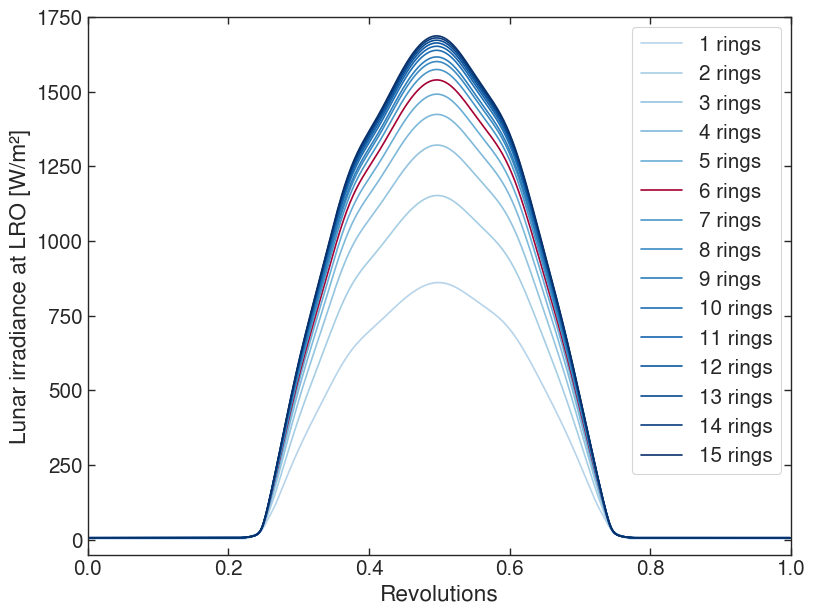

In [14]:
def plot_paneling_convergence():
    results_folder_rings = Path("../results/number_of_panels_per_ring_test-2023-08-17T14-33-31-ffcd7/")
    # results_folder_rings = Path("../results/number_of_panels_per_ring_test-2023-08-17T13-58-09-92f24/")
    metadata_rings, runs_rings = load_pickled_simulation_results(results_folder_rings)

    idxs = metadata_rings[
        (metadata_rings["albedo_distribution_moon"] == "DLAM1")
    ]
    dfs = {
        len(row.number_of_panels_per_ring_moon): runs_rings[row.Index] for row in idxs.itertuples()
    }
    dfs = dict(sorted(dfs.items(), key=lambda item: item[0]))
    dfs, labels = dfs.values(), dfs.keys()

    fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs, list(labels), cmap):
        if label == 6:
            color = "C1"
        print(label, df["irr_moon"].max(), abs(df["irr_moon"].max() / dfs[-1]["irr_moon"].max() - 1) * 100)
        ax.plot(get_revolutions_index(df), df["irr_moon"], label=f"{label} rings", c=color)

    ax.legend()

    ax.set_xlim([0, 1])
    ax.set_ylim([-50, 1751])
    ax.set_xlabel("Revolutions")
    ax.set_ylabel("Lunar irradiance at LRO [W/m²]")
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot()
    save_plot(plots_folder, "paneling_convergence")
    
plot_paneling_convergence()

# Target model

In [64]:
def generate_target_model_table():
    panels = pd.DataFrame.from_records([
        ("+X", 0.29, 0.22, 2.82, ""),
        ("-X", 0.39, 0.19, 2.82, ""),
        ("+Y", 0.32, 0.23, 3.69, ""),
        ("-Y", 0.32, 0.18, 3.69, ""),
        ("+Z", 0.32, 0.18, 5.14, ""),
        ("-Z", 0.54, 0.18, 5.14, ""),
        ("+SA", 0.05, 0.05, 11.00, "+Sun or fixed"),
        ("-SA", 0.30, 0.20, 11.00, "-Sun or fixed"),
        ("+HGA", 0.18, 0.28, 1.00, "+Earth"),
        ("-HGA", 0.019, 0.0495, 1.00, "-Earth")
    ], columns=["Panel", "Cs", "Cd", "A", "Tracking"]).convert_dtypes()
    panels["Ca"] = 1 - panels["Cs"] - panels["Cd"]
    
    # num = (panels["Ca"] * 2/3 * panels["A"]).sum()
    # denom = ((panels["Cd"] * 5/3 + panels["Ca"] + 2 * panels["Cs"]) * panels["A"]).sum()
    
    panels = panels[["Panel", "Ca", "Cs", "Cd", "A", "Tracking"]].rename(columns={
        "Ca": "$\mathbf C_a$",
        "Cs": "$\mathbf C_s$",
        "Cd": "$\mathbf C_d$",
        "A": r"$\mathbf A$~[\unit{\meter\squared}]",
        "Tracking": r"\bfseries Tracking"
    })

    table = (
        panels.style
        .format(precision=2)
        .applymap_index(lambda v: "font-weight: bold;", axis="columns")
        .applymap(lambda v: "font-weight: bold;", "Panel")
        .hide(axis="index")
        .to_latex(convert_css=True, hrules=True)
    )
    
    print(table)
    with open(tables_folder + "/target_model.tex", "w") as f:
        f.write(table)

generate_target_model_table()

\begin{tabular}{lrrrrl}
\toprule
\bfseries Panel & \bfseries $\mathbf C_a$ & \bfseries $\mathbf C_s$ & \bfseries $\mathbf C_d$ & \bfseries $\mathbf A$~[\unit{\meter\squared}] & \bfseries Tracking \\
\midrule
\bfseries +X & 0.49 & 0.29 & 0.22 & 2.82 &  \\
\bfseries -X & 0.42 & 0.39 & 0.19 & 2.82 &  \\
\bfseries +Y & 0.45 & 0.32 & 0.23 & 3.69 &  \\
\bfseries -Y & 0.50 & 0.32 & 0.18 & 3.69 &  \\
\bfseries +Z & 0.50 & 0.32 & 0.18 & 5.14 &  \\
\bfseries -Z & 0.28 & 0.54 & 0.18 & 5.14 &  \\
\bfseries +SA & 0.90 & 0.05 & 0.05 & 11.00 & +Sun or fixed \\
\bfseries -SA & 0.50 & 0.30 & 0.20 & 11.00 & -Sun or fixed \\
\bfseries +HGA & 0.54 & 0.18 & 0.28 & 1.00 & +Earth \\
\bfseries -HGA & 0.93 & 0.02 & 0.05 & 1.00 & -Earth \\
\bottomrule
\end{tabular}



In [16]:
def load_mass_history():
    def parse_line(line):
        date = pd.to_datetime(line[56:73], format="%Y %j %H:%M:%S", utc=True)
        fuel_mass = float(line[104:111])
        return date, fuel_mass

    dry_mass = 1020.9
    history = []
    for f in Path("files/lro_sff").glob("*.txt"):
        line_start, line_stop, _, line_avg = f.open().readlines()[2:6]
        average_mass = float(line_avg[103:111])
        history.append(parse_line(line_start) + (average_mass,))
        history.append(parse_line(line_stop) + (average_mass,))
    
    history = pd.DataFrame(history, columns=["date", "fuel_mass", "average_mass"]).set_index("date").sort_index()
    history["mass"] = dry_mass + history["fuel_mass"]
    return history

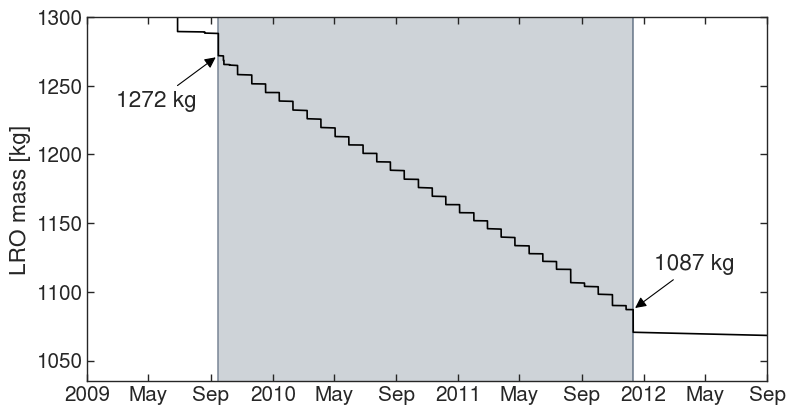

In [17]:
def plot_mass_history():
    mass_history = load_mass_history()

    fig, ax = plt.subplots(figsize=(8, 4))

    ax.axvline(datetime(2009, 9, 16), alpha=0.5)  # actually September 15
    ax.axvline(datetime(2011, 12, 11), alpha=0.5)  # actually December 11
    ax.axvspan(datetime(2009, 9, 16), datetime(2011, 12, 11), alpha=0.2)

    # ax.annotate("LRO science mission", (datetime(2009, 9, 15), 1350), xytext=(5, -5), textcoords="offset points", va="top")

    start_mass = get_closest_before(mass_history, datetime(2009, 9, 16, tzinfo=timezone.utc))["mass"]
    ax.annotate(
        f"{start_mass:.0f} kg",
        (datetime(2009, 9, 15), start_mass),
        xytext=(-15, -25),
        va="top",
        ha="right",
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black")
    )

    end_mass = get_closest_after(mass_history, datetime(2011, 12, 10, tzinfo=timezone.utc))["mass"]
    ax.annotate(
        f"{end_mass:.0f} kg",
        (datetime(2011, 12, 11), end_mass),
        xytext=(15, 25),
        va="bottom",
        ha="left",
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black")
    )

    ax.plot(mass_history.index, mass_history["mass"], color="black")

    # ax.set_xlabel("Date")
    ax.set_ylabel("LRO mass [kg]")
    ax.set_xlim([datetime(2009, 1, 1), datetime(2012, 9, 1)])
    ax.set_ylim([1035, 1300])

    # ax.set_xticklabels(ax.get_xticklabels())

    format_plot(x_major_locator=matplotlib.dates.AutoDateLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    save_plot(plots_folder, "mass_history")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_mass_history()

# Performance benchmark

In [501]:
metadata_benchmark = load_pickled_simulation_results("../results/full-benchmark-2023-08-20T12-38-39-779f0")
# metadata_benchmark = load_pickled_simulation_results("../results/full-benchmark-2023-08-17T15-23-23-792e0")
metadata_benchmark = metadata_benchmark[variable_columns + ["walltime_propagation", "walltime_total"]]

In [502]:
# Average over dates
# metadata_benchmark = metadata_benchmark\
#     .groupby(list(set(variable_columns) - set(["simulation_start"])))\
#     .agg({"walltime_propagation": "mean", "walltime_total": "sum"})\
#     .reset_index()
metadata_benchmark

use_occultation albedo_distribution_moon  use_moon_radiation  \
0              True                                        False   
1              True                                        False   
2              True                                        False   
3              True                 Constant                True   
4              True                 Constant                True   
5              True                 Constant                True   
6              True                 Constant                True   
7              True                    DLAM1                True   
8              True                    DLAM1                True   
9              True                    DLAM1                True   
10             True                    DLAM1                True   

    use_solar_radiation target_type walltime_propagation  \
0                 False  Cannonball           263.851814   
1                  True  Cannonball           257.718588   
2                  True     Paneled           266.859959   
3                 False  Cannonball           298.590571   
4                 False     Paneled           324.504766   
5                  True  Cannonball           301.258134   
6                  True     Paneled           321.159896   
7                 False  Cannonball           526.630834   
8                 False     Paneled           518.364991   
9                  True  Cannonball           537.022767   
10                 True     Paneled             516.5367   

                                       walltime_total  
0   [267.4039104748517, 265.1369985733181, 264.803...  
1   [264.27857063151896, 260.0515791513026, 258.17...  
2   [300.19971602782607, 294.0809587929398, 268.55...  
3   [304.07794459350407, 304.69567049108446, 303.4...  
4   [326.81036519631743, 325.2657754160464, 324.46...  
5   [301.65485937334597, 303.291189474985, 304.532...  
6   [325.0796633698046, 327.92450401745737, 324.26...  
7   [529.6452952288091, 529.2638691812754, 532.954...  
8   [577.4904679730535, 548.1092925444245, 553.414...  
9   [529.1952495649457, 535.7729607485235, 540.773...  
10  [549.2759976312518, 552.3190176598728, 555.179...

In [503]:
def get_benchmark_times(use_solar, use_lunar, target_type, albedo, use_occultation):
    df = metadata_benchmark[
        (metadata_benchmark["use_solar_radiation"] == use_solar) &
        (metadata_benchmark["use_moon_radiation"] == use_lunar) &
        (metadata_benchmark["target_type"] == target_type) &
        (metadata_benchmark["albedo_distribution_moon"] == albedo) &
        (metadata_benchmark["use_occultation"] == use_occultation)
    ]
    if len(df.index) > 1:
        raise ValueError("More than one run found")
    return np.array(df.iloc[0]["walltime_total"])

In [504]:
# fig, ax = plt.subplots()

# sns.stripplot(x=get_benchmark_times("2010 JUN 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 JUN 26")
# sns.stripplot(x=get_benchmark_times("2010 SEP 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 SEP 26")
# sns.pointplot(x=get_benchmark_times("2010 JUN 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 JUN 26", markers="d", ci=None)
# sns.pointplot(x=get_benchmark_times("2010 SEP 26", False, True, "Paneled", "DLAM1", True), ax=ax, label="2010 SEP 26", markers="d", ci=None)
# ax.legend()

/home/dominik/dev/hpb-project/venv/lib/python3.11/site-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


<Axes: >

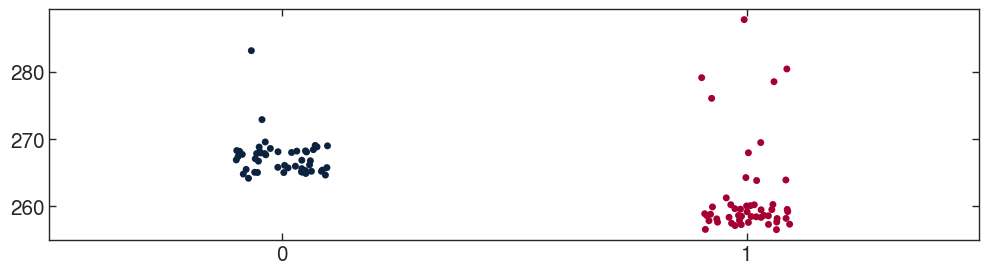

In [505]:
sb.stripplot([
    get_benchmark_times(False, False, "Cannonball", "", True),
    get_benchmark_times(True, False, "Cannonball", "", True)
])

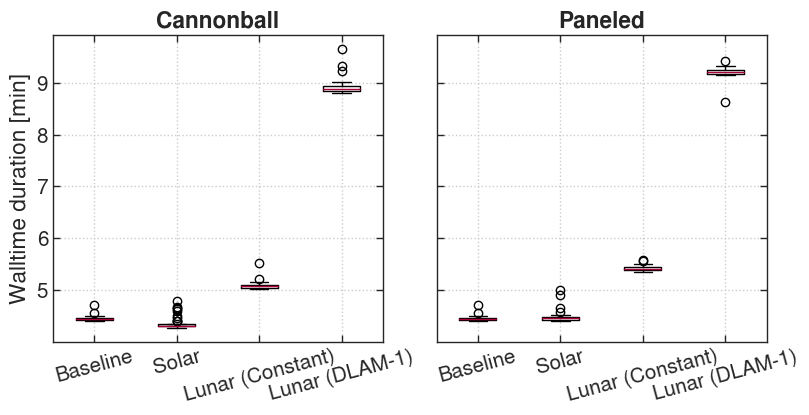

In [506]:
def plot_performance():
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey="all")
    
    for ax, target_type in zip(axs, ["Cannonball", "Paneled"]):
        times_baseline = get_benchmark_times(False, False, "Cannonball", "", True)
        times_solar = get_benchmark_times(True, False, target_type, "", True)
        times_lunar_const = get_benchmark_times(True, True, target_type, "Constant", True)
        times_lunar_dlam = get_benchmark_times(True, True, target_type, "DLAM1", True)

        ax.boxplot(
            [times_baseline / 60, times_solar / 60, times_lunar_const / 60, times_lunar_dlam / 60],
            labels=["Baseline", "Solar", "Lunar (Constant)", "Lunar (DLAM-1)"],
        )

        ax.set_xticklabels(ax.get_xticklabels(), ha="center", rotation=15)
        ax.set_title(target_type)
    
    # axs[0].set_ylim([0, max([ax.get_ylim()[1] for ax in axs])])
    
    axs[0].set_ylabel("Walltime duration [min]")

    format_plot(major_grid=True)
    save_plot(plots_folder, "performance")

plot_performance()

# Effect of instantaneous reradiation

                                               0             1             2
Solar         2011 SEP 26 18:00:00  1.738080e-08  1.913359e-08  4.884430e-10
              2010 JUN 28 15:00:00  3.329818e-10  1.326517e-08  1.942136e-08
Lunar         2011 SEP 26 18:00:00  8.635328e-09  2.319600e-09  3.105514e-11
              2010 JUN 28 15:00:00  1.032149e-10  2.197266e-10  3.188425e-10
Solar + Lunar 2011 SEP 26 18:00:00  9.254726e-09  1.815581e-08  4.910603e-10
              2010 JUN 28 15:00:00  3.821600e-10  1.347914e-08  1.973071e-08


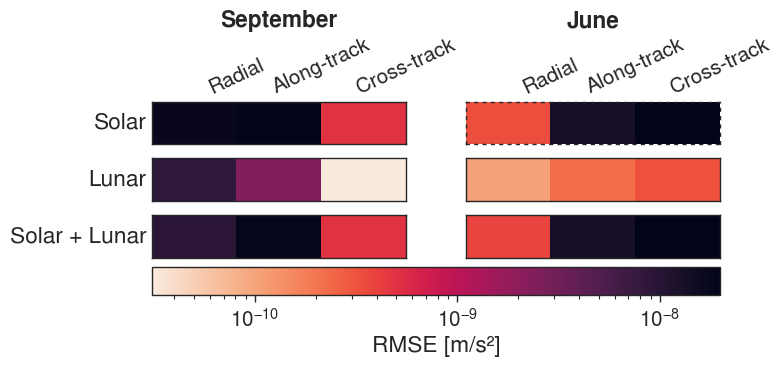

In [311]:
def plot_instant_reradiation_diffs():
    results_folder_rerad = Path("../results/instantaneous_reradiation_test-2023-08-19T11-39-01-0e203")
    metadata_rerad, runs_rerad = load_pickled_simulation_results(results_folder_rerad)
    metadata_rerad = metadata_rerad[metadata_rerad["use_solar_radiation"] & metadata_rerad["use_moon_radiation"]]

    sources = ["Solar", "Lunar", "Solar + Lunar"]
    dates = metadata_rerad["simulation_start"].unique()

    rms = {}

    for source, date in itertools.product(sources, dates):
        df_with = runs_rerad[
            metadata_rerad[
                (metadata_rerad["simulation_start"] == date) & metadata_rerad["with_instantaneous_reradiation"].astype(bool)
        ].index[0]]
        df_without = runs_rerad[
            metadata_rerad[
                (metadata_rerad["simulation_start"] == date) & ~metadata_rerad["with_instantaneous_reradiation"].astype(bool)
        ].index[0]]
        df_with = trim_df_revolutions(df_with)
        df_without = trim_df_revolutions(df_without)

        rms_run = []
        for comp in ["radial", "along", "cross"]:
            if source == "Solar":
                ser_with = df_with["acc_rp_sun_" + comp]
                ser_without = df_without["acc_rp_sun_" + comp]
            elif source == "Lunar":
                ser_with = df_with["acc_rp_moon_" + comp]
                ser_without = df_without["acc_rp_moon_" + comp]
            elif source == "Solar + Lunar":
                ser_with = df_with["acc_rp_sun_" + comp] + df_with["acc_rp_moon_" + comp]
                ser_without = df_without["acc_rp_sun_" + comp] + df_without["acc_rp_moon_" + comp]
            
            rms_run.append(rmse(ser_with, ser_without))

        rms[(source, date)] = rms_run
    
    print(pd.DataFrame(rms).T)

    fig, axs = plt.subplots(3, 2, figsize=(7*1.1, 3.2*1.1), constrained_layout=True)

    minmin = np.min(list(rms.values()))
    maxmax = np.max(list(rms.values()))
    norm = matplotlib.colors.LogNorm(vmin=minmin, vmax=maxmax)
    cmap = "rocket_r"

    for (i, source), (j, date) in itertools.product(enumerate(sources), enumerate(dates)):
        ax = axs[i, j]
        ax.imshow(np.atleast_2d(rms[(source, date)]), cmap=cmap, norm=norm, aspect=0.5)
        ax.tick_params(left=False, bottom=False, right=False, top=False, labelleft=False, labelbottom=False)

        if source == "Solar" and "JUN" in date:
            ax.spines[:].set_linestyle((0, (2, 4)))
    
    for i, source in enumerate(sources):
        ax = axs[i, 0]
        ax.set_ylabel(source, rotation=0, ha="right", va="center")

    for j, date in enumerate(dates):
        ax = axs[0, j]
        ax.set_title({
            "2010 JUN 28 15:00:00": "June",
            "2011 SEP 26 18:00:00": "September",
        }[date])
        ax.tick_params(labeltop=True, labelrotation=25)
        ax.set_xticks([0.5, 1.5, 2.5], ["Radial", "Along-track", "Cross-track"], ha="center")
    
    cb = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs,
        orientation='horizontal',
        fraction=.2, pad=0.05)
    cb.ax.set_xlabel("RMSE [m/s²]")
    cb.ax.tick_params(direction="out", which="both")
    cb.ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs="auto"))
    cb.update_ticks()

    save_plot(plots_folder, "acc_reradiation_rms")

plot_instant_reradiation_diffs()

                                            0           1          2
Solar         2011 SEP 26 18:00:00  39.293244   45.757254  32.115047
              2010 JUN 28 15:00:00  70.222138  565.695724  33.298427
Lunar         2011 SEP 26 18:00:00  26.612498   38.400003   9.475095
              2010 JUN 28 15:00:00  14.996651  138.738653  38.153366
Solar + Lunar 2011 SEP 26 18:00:00  74.374149   46.790190  38.079118
              2010 JUN 28 15:00:00  47.898734  538.738893  33.362636


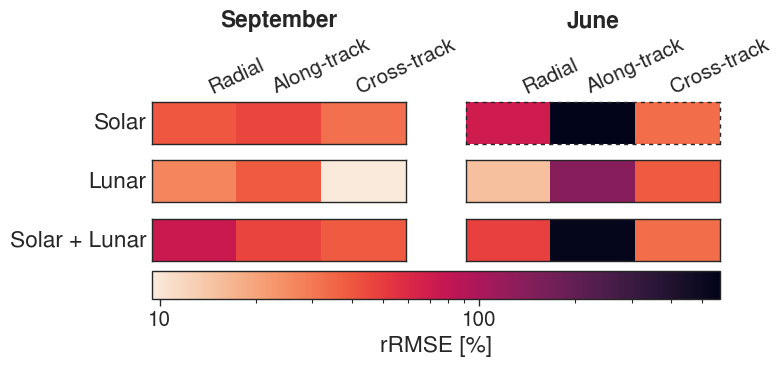

In [310]:
def plot_instant_reradiation_relative_diffs():
    results_folder_rerad = Path("../results/instantaneous_reradiation_test-2023-08-19T11-39-01-0e203")
    metadata_rerad, runs_rerad = load_pickled_simulation_results(results_folder_rerad)
    metadata_rerad = metadata_rerad[metadata_rerad["use_solar_radiation"] & metadata_rerad["use_moon_radiation"]]

    sources = ["Solar", "Lunar", "Solar + Lunar"]
    dates = metadata_rerad["simulation_start"].unique()

    rms = {}

    for source, date in itertools.product(sources, dates):
        df_with = runs_rerad[
            metadata_rerad[
                (metadata_rerad["simulation_start"] == date) & metadata_rerad["with_instantaneous_reradiation"].astype(bool)
        ].index[0]]
        df_without = runs_rerad[
            metadata_rerad[
                (metadata_rerad["simulation_start"] == date) & ~metadata_rerad["with_instantaneous_reradiation"].astype(bool)
        ].index[0]]
        df_with = trim_df_revolutions(df_with)
        df_without = trim_df_revolutions(df_without)

        rms_run = []
        for comp in ["radial", "along", "cross"]:
            if source == "Solar":
                ser_with = df_with["acc_rp_sun_" + comp]
                ser_without = df_without["acc_rp_sun_" + comp]
            elif source == "Lunar":
                ser_with = df_with["acc_rp_moon_" + comp]
                ser_without = df_without["acc_rp_moon_" + comp]
            elif source == "Solar + Lunar":
                ser_with = df_with["acc_rp_sun_" + comp] + df_with["acc_rp_moon_" + comp]
                ser_without = df_without["acc_rp_sun_" + comp] + df_without["acc_rp_moon_" + comp]
            
            rms_run.append(rrmse(ser_with, ser_without) * 100)

        rms[(source, date)] = rms_run
        
    print(pd.DataFrame(rms).T)

    fig, axs = plt.subplots(3, 2, figsize=(7*1.1, 3.2*1.1), constrained_layout=True)

    minmin = np.min(list(rms.values()))
    maxmax = np.max(list(rms.values()))
    norm = matplotlib.colors.LogNorm(vmin=minmin, vmax=maxmax)
    cmap = "rocket_r"

    for (i, source), (j, date) in itertools.product(enumerate(sources), enumerate(dates)):
        ax = axs[i, j]
        ax.imshow(np.atleast_2d(rms[(source, date)]), cmap=cmap, norm=norm, aspect=0.5)
        ax.tick_params(left=False, bottom=False, right=False, top=False, labelleft=False, labelbottom=False)

        if source == "Solar" and "JUN" in date:
            ax.spines[:].set_linestyle((0, (2, 4)))
    
    for i, source in enumerate(sources):
        ax = axs[i, 0]
        ax.set_ylabel(source, rotation=0, ha="right", va="center")

    for j, date in enumerate(dates):
        ax = axs[0, j]
        ax.set_title({
            "2010 JUN 28 15:00:00": "June",
            "2011 SEP 26 18:00:00": "September",
        }[date])
        ax.tick_params(labeltop=True, labelrotation=25)
        ax.set_xticks([0.5, 1.5, 2.5], ["Radial", "Along-track", "Cross-track"], ha="center")
    
    cb = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs,
        orientation='horizontal',
        fraction=.2, pad=0.05)
    cb.ax.set_xlabel("rRMSE [%]")
    cb.ax.tick_params(direction="out", which="both")
    cb.ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10, subs="auto"))
    cb.update_ticks()
    cb.ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0f}"))

    save_plot(plots_folder, "acc_reradiation_rrms")


plot_instant_reradiation_relative_diffs()

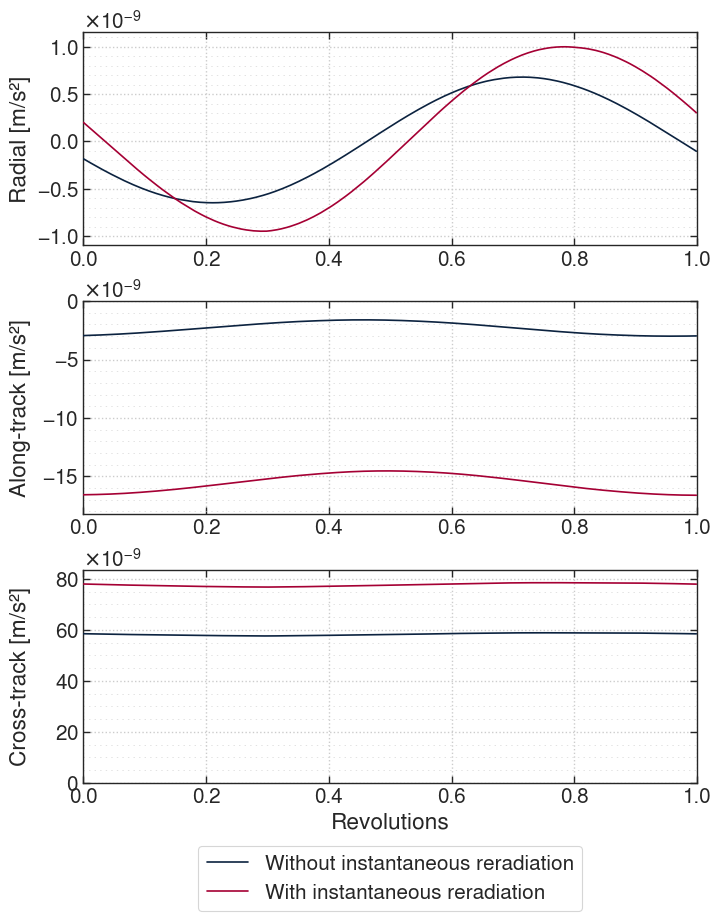

In [356]:
def plot_instant_reradiation_acc(source, start_date, start_rev, filename):
    results_folder_rerad = Path("../results/instantaneous_reradiation_test-2023-08-19T11-39-01-0e203")
    metadata_rerad, runs_rerad = load_pickled_simulation_results(results_folder_rerad)

    fig, axs = plt.subplots(3, figsize=(7, 9))

    df_with_rerad = runs_rerad[
        metadata_rerad[
            (metadata_rerad["simulation_start"] == start_date) &
            metadata_rerad["use_moon_radiation"] &
            metadata_rerad["use_solar_radiation"] &
            metadata_rerad["with_instantaneous_reradiation"].astype(bool)
    ].index[0]]
    df_without_rerad = runs_rerad[
        metadata_rerad[
            (metadata_rerad["simulation_start"] == start_date) &
            metadata_rerad["use_moon_radiation"] &
            metadata_rerad["use_solar_radiation"] &
            ~metadata_rerad["with_instantaneous_reradiation"].astype(bool)
    ].index[0]]

    df_without_rerad = trim_df_revolutions(df_without_rerad, start_rev)
    df_with_rerad = trim_df_revolutions(df_with_rerad, start_rev)

    for comp, ax in zip(["radial", "along", "cross"], axs):
        if comp == "magnitude":
            col = f"acc_rp_{source}"
        else:
            col = f"acc_rp_{source}_{comp}"

        ax.plot(df_without_rerad.index, df_without_rerad[col], label="Without instantaneous reradiation", zorder=3)
        ax.plot(df_with_rerad.index, df_with_rerad[col], label="With instantaneous reradiation", zorder=4)
        # ax.plot(df_with_rerad.index, df_with_rerad[col] * df_without_rerad[col].abs().max() / df_with_rerad[col].abs().max(), label="With instantaneous reradiation (scaled)", c="C1", alpha=0.5, zorder=2)
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0] * 1.05), max(0, ax.get_ylim()[1] * 1.05)])
        ax.set_xlim([0, 1])
    
    for ax, name in zip(axs.flat, ["Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" [m/s²]")

    axs[-1].set_xlabel("Revolutions")
    axs[-1].legend(bbox_to_anchor=(0.5, -0.65), loc="lower center")

    format_plot(major_grid=True, minor_grid=True, x_minor_locator=NullLocator())
    save_plot(plots_folder, filename)

plot_instant_reradiation_acc("sun", "2010 JUN 28 15:00:00", 0.1, "acc_reradiation_sun_jun")

# Load data

In [327]:
metadata, runs = load_pickled_simulation_results("../results/full-2023-08-20T12-00-58-de219")
# metadata, runs = load_pickled_simulation_results("../results/full-2023-08-19T10-39-56-786fb")
metadata["albedo_distribution_moon"] = metadata["albedo_distribution_moon"].replace({
    "DLAM1": "DLAM-1",
    "Constant": "constant"
})

In [328]:
metadata[variable_columns]

simulation_start use_solar_radiation use_moon_radiation target_type  \
1   2011 SEP 26 18:00:00               False               True  Cannonball   
2   2010 JUN 28 15:00:00                True               True     Paneled   
3   2011 SEP 26 18:00:00                True               True     Paneled   
4   2011 SEP 26 18:00:00                True               True  Cannonball   
5   2011 SEP 26 18:00:00                True               True     Paneled   
6   2011 SEP 26 18:00:00               False               True  Cannonball   
7   2011 SEP 26 18:00:00               False               True     Paneled   
8   2010 JUN 28 15:00:00               False               True  Cannonball   
9   2011 SEP 26 18:00:00               False               True  Cannonball   
10  2011 SEP 26 18:00:00               False               True     Paneled   
11  2010 JUN 28 15:00:00               False               True     Paneled   
12  2010 JUN 28 15:00:00                True               True  Cannonball   
13  2011 SEP 26 18:00:00               False               True     Paneled   
14  2010 JUN 28 15:00:00                True               True  Cannonball   
15  2011 SEP 26 18:00:00               False               True  Cannonball   
16  2011 SEP 26 18:00:00                True               True  Cannonball   
17  2010 JUN 28 15:00:00                True               True     Paneled   
18  2011 SEP 26 18:00:00                True               True     Paneled   
19  2010 JUN 28 15:00:00               False               True  Cannonball   
20  2010 JUN 28 15:00:00               False               True     Paneled   
21  2010 JUN 28 15:00:00                True               True     Paneled   
22  2011 SEP 26 18:00:00               False               True     Paneled   
23  2011 SEP 26 18:00:00                True               True     Paneled   
24  2010 JUN 28 15:00:00               False               True  Cannonball   
25  2010 JUN 28 15:00:00               False               True     Paneled   
26  2010 JUN 28 15:00:00                True               True  Cannonball   
27  2011 SEP 26 18:00:00                True               True  Cannonball   
28  2011 SEP 26 18:00:00               False               True     Paneled   
29  2010 JUN 28 15:00:00                True              False     Paneled   
30  2011 SEP 26 18:00:00               False               True  Cannonball   
31  2010 JUN 28 15:00:00               False               True     Paneled   
32  2010 JUN 28 15:00:00                True               True     Paneled   
33  2011 SEP 26 18:00:00                True               True  Cannonball   
34  2010 JUN 28 15:00:00                True               True  Cannonball   
35  2010 JUN 28 15:00:00               False               True  Cannonball   
36  2011 SEP 26 18:00:00                True              False  Cannonball   
37  2011 SEP 26 18:00:00                True              False     Paneled   
38  2010 JUN 28 15:00:00                True              False  Cannonball   
39  2011 SEP 26 18:00:00                True               True  Cannonball   
40  2010 JUN 28 15:00:00                True               True     Paneled   
41  2010 JUN 28 15:00:00               False               True  Cannonball   
42  2011 SEP 26 18:00:00                True               True     Paneled   
43  2010 JUN 28 15:00:00               False               True     Paneled   
44  2010 JUN 28 15:00:00                True               True  Cannonball   
45  2010 JUN 28 15:00:00               False              False  Cannonball   
46  2011 SEP 26 18:00:00               False              False  Cannonball   

   albedo_distribution_moon use_occultation  
1                  constant            True  
2                  constant            True  
3                  NoAlbedo            True  
4                    DLAM-1            True  
5                  constant            True  
6                 

In [329]:
simulation_dates = list(metadata["simulation_start"].unique())
simulation_dates

['2011 SEP 26 18:00:00', '2010 JUN 28 15:00:00']

In [330]:
def get_baseline(start_date):
    for date in metadata["simulation_start"].unique():
        if date.startswith(start_date):
            start_date = date
            break

    df = metadata[
        (metadata["simulation_start"] == start_date) &
        (metadata["use_solar_radiation"] == False) &
        (metadata["use_moon_radiation"] == False)
    ]
    if len(df.index) > 1:
        raise ValueError("More than one run found")
    return runs[df.index[0]].copy()

In [331]:
def get_run(start_date, use_solar, use_lunar, target_type, albedo, thermal):
    for date in metadata["simulation_start"].unique():
        if date.startswith(start_date):
            start_date = date
            break

    df = metadata[
        (metadata["simulation_start"] == start_date) &
        (metadata["use_solar_radiation"] == use_solar) &
        (metadata["use_moon_radiation"] == use_lunar) &
        (metadata["target_type"] == target_type) &
        (metadata["albedo_distribution_moon"] == albedo) &
        (metadata["thermal_type_moon"] == thermal)
    ]
    if len(df.index) > 1:
        raise ValueError("More than one run found")
    return runs[df.index[0]].copy()

# Orbit geometry

In [332]:
duration = metadata["simulation_duration"].iloc[0]
for start_date in metadata["simulation_start"].unique():
    print(start_date)
    start_date_et = as_et(start_date)
    print(" Beta", get_lro_beta_angle(start_date_et))
    print(" Sun distance", get_distance("Sun", "LRO", start_date_et) / astronomical_unit)

    end_date_et = start_date_et + duration
    print(" Beta", get_lro_beta_angle(end_date_et))
    print(" Sun distance", get_distance("Sun", "LRO", end_date_et) / astronomical_unit)

    h = get_baseline(start_date)["h"] / 1e3
    print(" Altitude range", h.min(), h.max())

    print()

2011 SEP 26 18:00:00
 Beta -1.7095639214208802
 Sun distance 1.0002599966486814
 Beta -3.5557992386268182
 Sun distance 0.9997387761189371
 Altitude range 36.450651669237295 65.3104140359084

2010 JUN 28 15:00:00
 Beta 88.88225981064335
 Sun distance 1.0190047947159588
 Beta 88.78453027686777
 Sun distance 1.0183046853123707
 Altitude range 37.029231540819396 64.17332282535939



# Accelerations

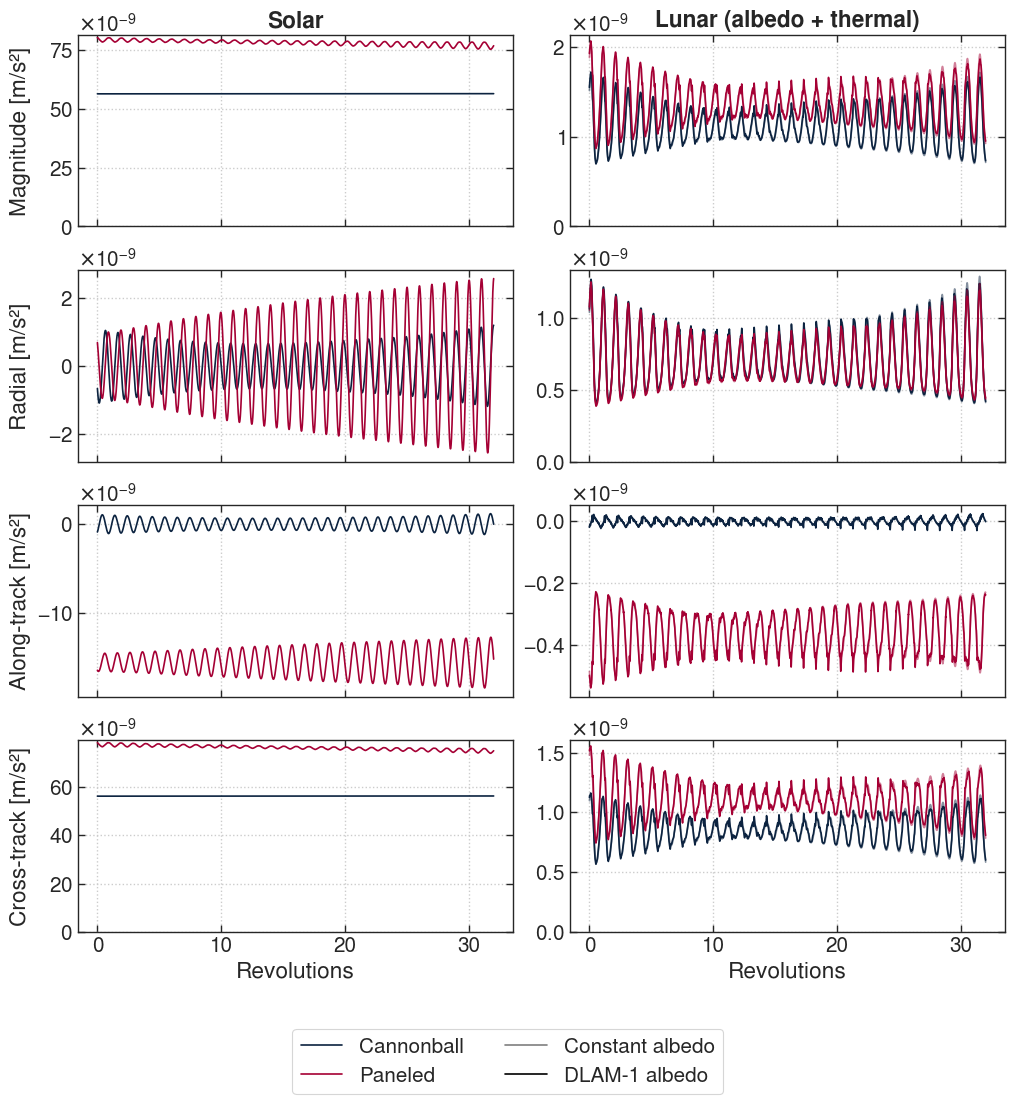

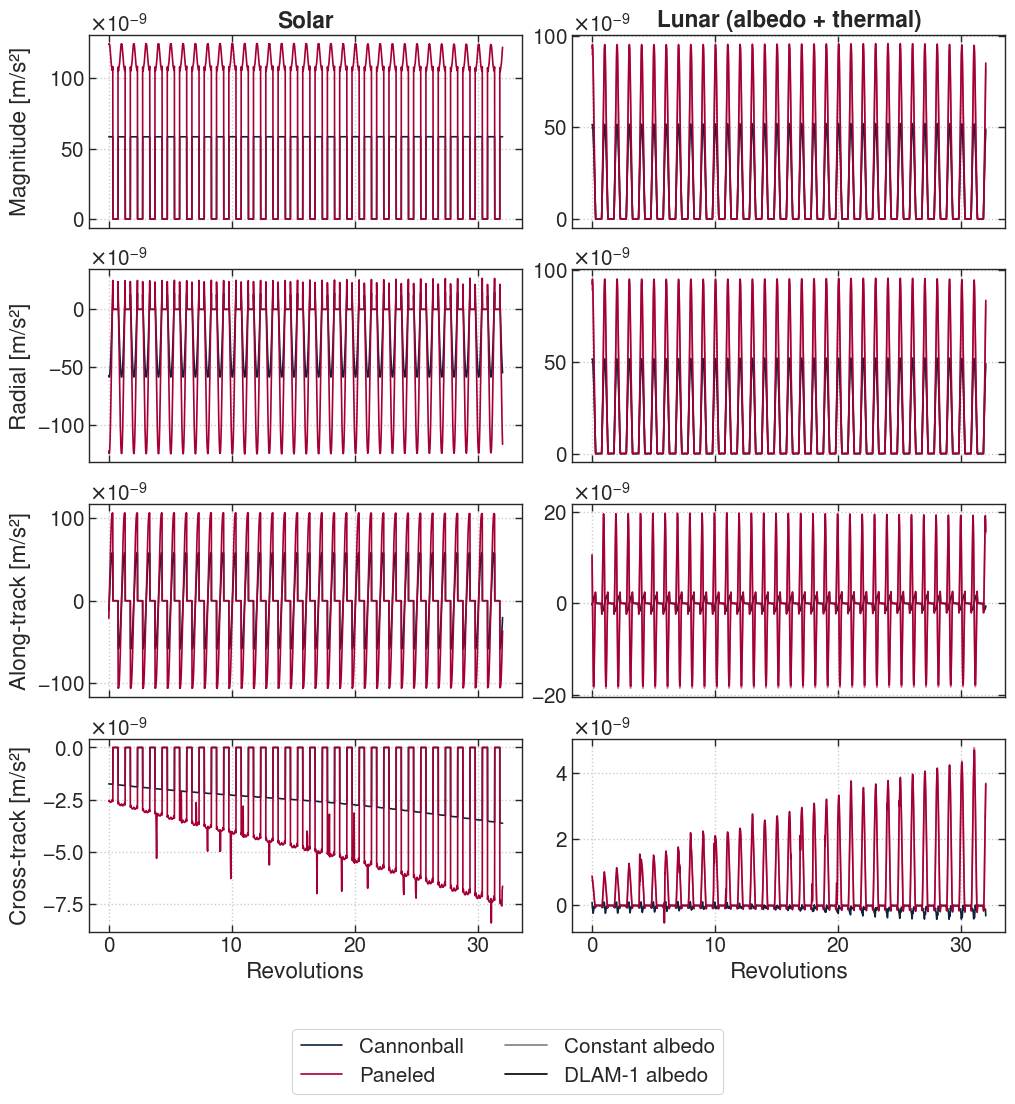

In [511]:
def plot_rp_accelerations(start_date):
    fig, axs = plt.subplots(4, 2, figsize=(10, 10), sharex="all")

    for i, (target_type, albedo_distribution_moon) in enumerate(itertools.product(["Cannonball", "Paneled"], ["constant", "DLAM-1"])):
        run = get_run(start_date, True, True, target_type, albedo_distribution_moon, "AngleBased")
        time = get_revolutions_index(run)

        color = f"C{int(target_type == 'Paneled')}"
        alpha = 0.5 if albedo_distribution_moon == "constant" else 1

        # run = run.rolling(orbit_steps).mean()

        if albedo_distribution_moon == "constant":
            ax_mag, ax_radial, ax_along, ax_cross = axs[:, 0]
            ax_mag.plot(time, run[f"acc_rp_sun"], color=color)
            ax_radial.plot(time, run[f"acc_rp_sun_radial"], color=color)
            ax_along.plot(time, run[f"acc_rp_sun_along"], color=color)
            ax_cross.plot(time, run[f"acc_rp_sun_cross"], color=color)

        ax_mag, ax_radial, ax_along, ax_cross = axs[:, 1]
        ax_mag.plot(time, run[f"acc_rp_moon"], alpha=alpha, color=color)
        ax_radial.plot(time, run[f"acc_rp_moon_radial"], alpha=alpha, color=color)
        ax_along.plot(time, run[f"acc_rp_moon_along"], alpha=alpha, color=color)
        ax_cross.plot(time, run[f"acc_rp_moon_cross"], alpha=alpha, color=color)
    
    fig.legend(
        [
            Line2D([0], [0], color="C0"),
            Line2D([0], [0], color="C1"),
            Line2D([0], [0], color="black", alpha=0.5),
            Line2D([0], [0], color="black", alpha=1),
        ],
        ["Cannonball", "Paneled", "Constant albedo", "DLAM-1 albedo"],
        bbox_to_anchor=(0.5, -0.12), loc="lower center", ncol=2)

    axs[0, 0].set_title("Solar")
    axs[0, 1].set_title("Lunar (albedo + thermal)")

    for ax in axs[-1, :].flat:
        # Last row
        # ax.set_xlim(17, 20)
        ax.set_xlabel("Revolutions")

    for ax, name in zip(axs[:, 0].flat, ["Magnitude", "Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" [m/s²]")
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0]), max(0, ax.get_ylim()[1])])
    
    format_plot(major_grid=True)

plot_rp_accelerations("2010 JUN 28")
plot_rp_accelerations("2011 SEP 26")

No interesting evolution, only changes are due to slight change in beta angle.

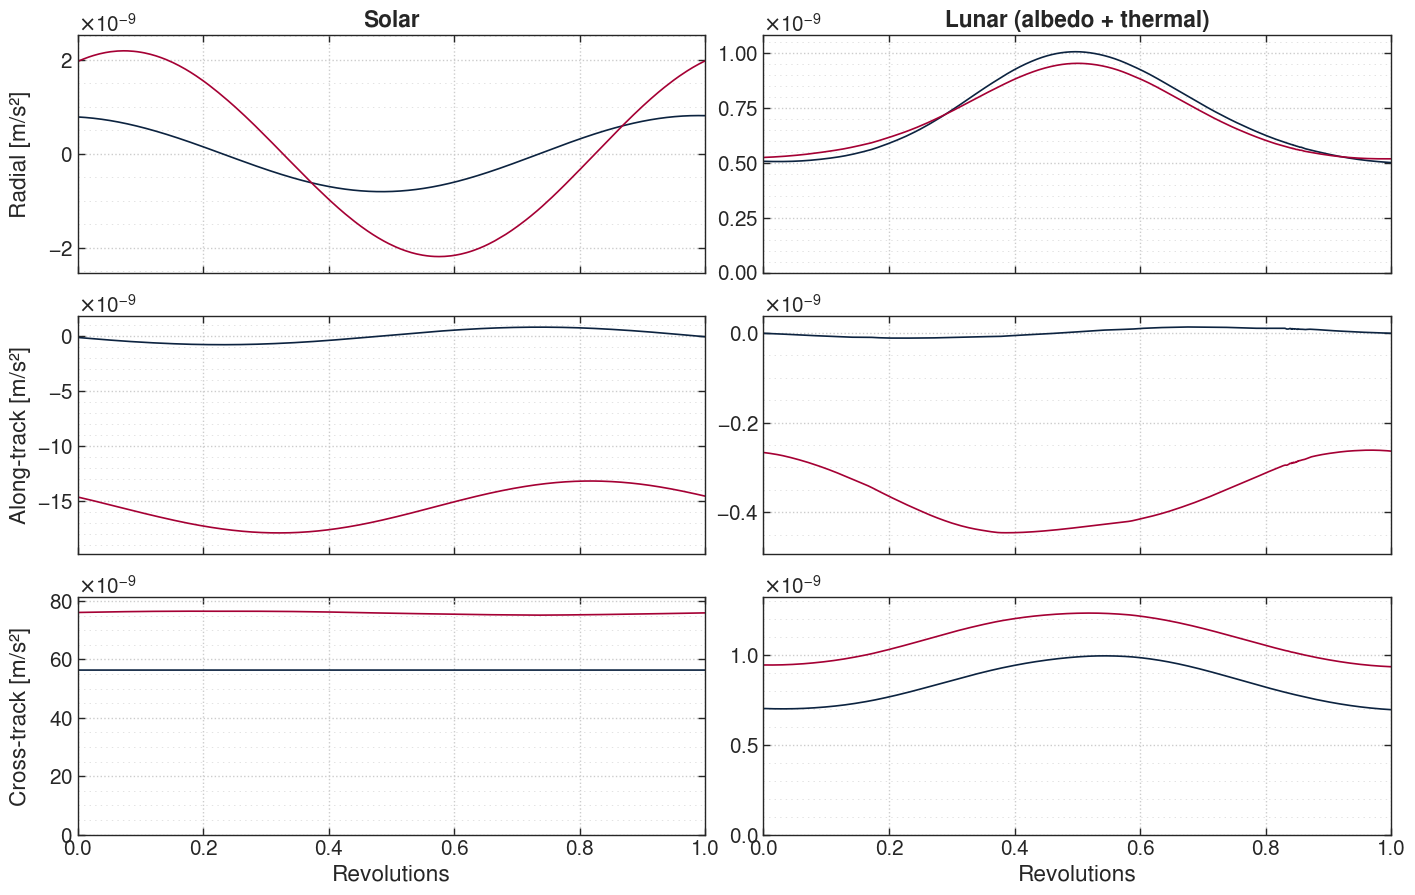

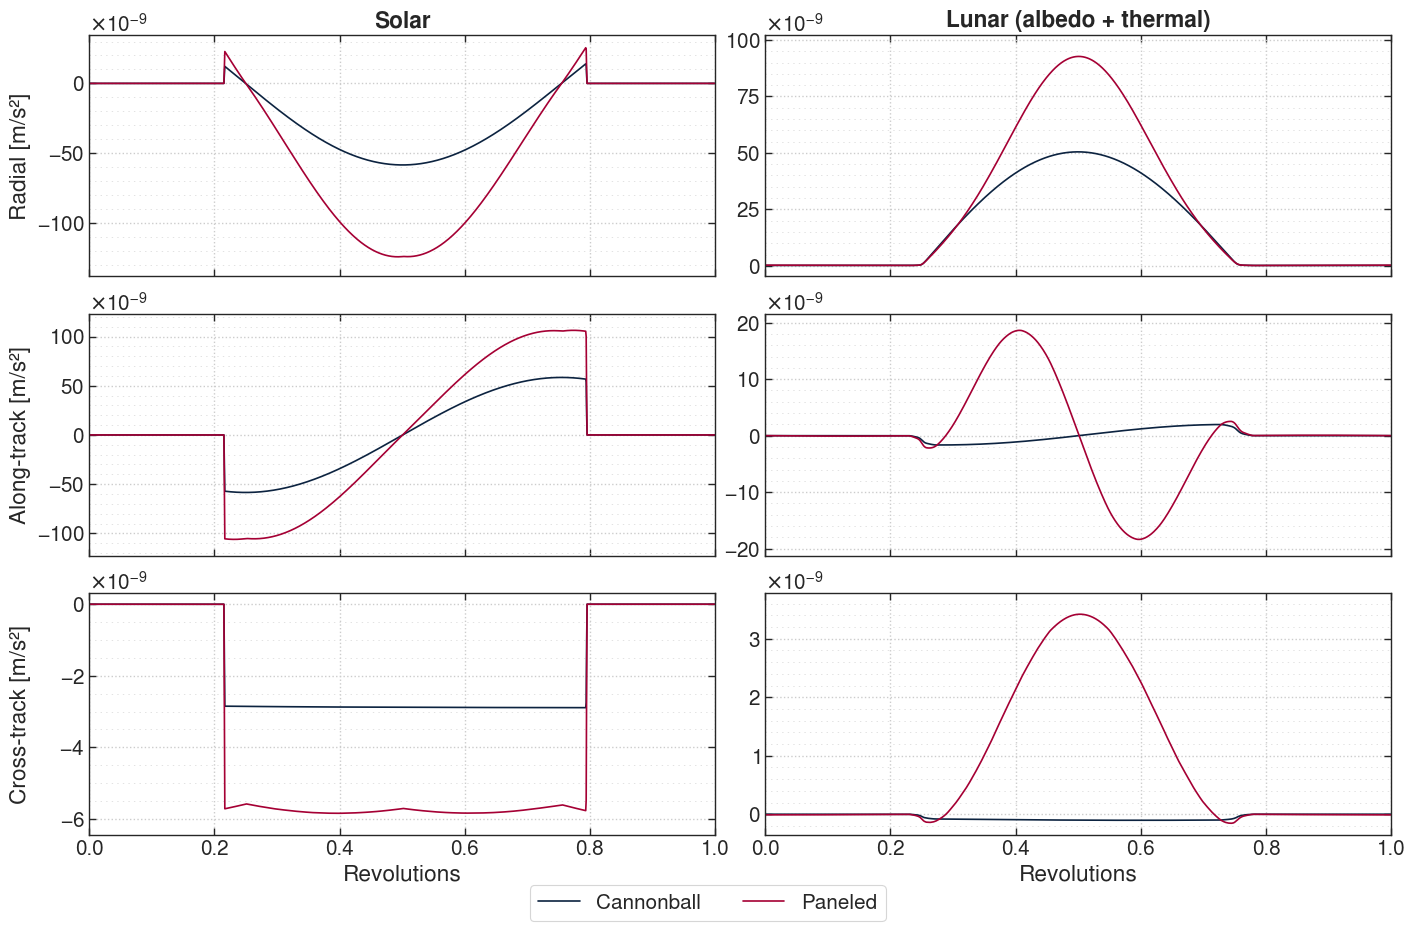

In [435]:
def plot_acc_solarvslunar_single_orbit(start_date, start_index, filename, legend=True):
    fig, axs = plt.subplots(3, 2, figsize=(14, 8.8), sharex="all")

    for i, target_type in enumerate(["Cannonball", "Paneled"]):
        run = get_run(start_date, True, True, target_type, "constant", "AngleBased")
        run = trim_df_revolutions(run, start_index)
        time = run.index

        color = f"C{int(target_type == 'Paneled')}"

        ax_radial, ax_along, ax_cross = axs[:, 0]
        ax_radial.plot(time, run[f"acc_rp_sun_radial"], color=color)
        ax_along.plot(time, run[f"acc_rp_sun_along"], color=color)
        ax_cross.plot(time, run[f"acc_rp_sun_cross"], color=color)

        ax_radial, ax_along, ax_cross = axs[:, 1]
        ax_radial.plot(time, run[f"acc_rp_moon_radial"], color=color)
        ax_along.plot(time, run[f"acc_rp_moon_along"], color=color)
        ax_cross.plot(time, run[f"acc_rp_moon_cross"], color=color)
    
    if legend:
        fig.legend(
            [
                Line2D([0], [0], color="C0"),
                Line2D([0], [0], color="C1"),
            ],
            ["Cannonball", "Paneled"],
            bbox_to_anchor=(0.5, -0.05), loc="lower center", ncols=2)

    axs[0, 0].set_title("Solar")
    axs[0, 1].set_title("Lunar (albedo + thermal)")

    for ax in axs[-1, :].flat:
        # Last row
        ax.set_xlim([0, 1])
        ax.set_xlabel("Revolutions")

    for ax, name in zip(axs[:, 0].flat, ["Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" [m/s²]")
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0] * 1.05), max(0, ax.get_ylim()[1] * 1.05)])
    
    format_plot(major_grid=True, minor_grid=True, x_minor_locator=NullLocator())
    save_plot(plots_folder, filename)

plot_acc_solarvslunar_single_orbit("2010 JUN 28", 21.92, "acc_solarvslunar_jun", legend=False)
plot_acc_solarvslunar_single_orbit("2011 SEP 26", 21.55, "acc_solarvslunar_sep")

2010 JUN 28 6.255311623699332e-11 18.78297660373607 19.970369425296408 20.933990112684313 18.316241207621538
9.452320655773068e-10 23.9896059404406
2011 SEP 26 4.939129616798953e-09 24.480645274329436 24.557314595018983 23.592873487639782 15.115608888169717
1.543980883111186e-10 5.83825508720221


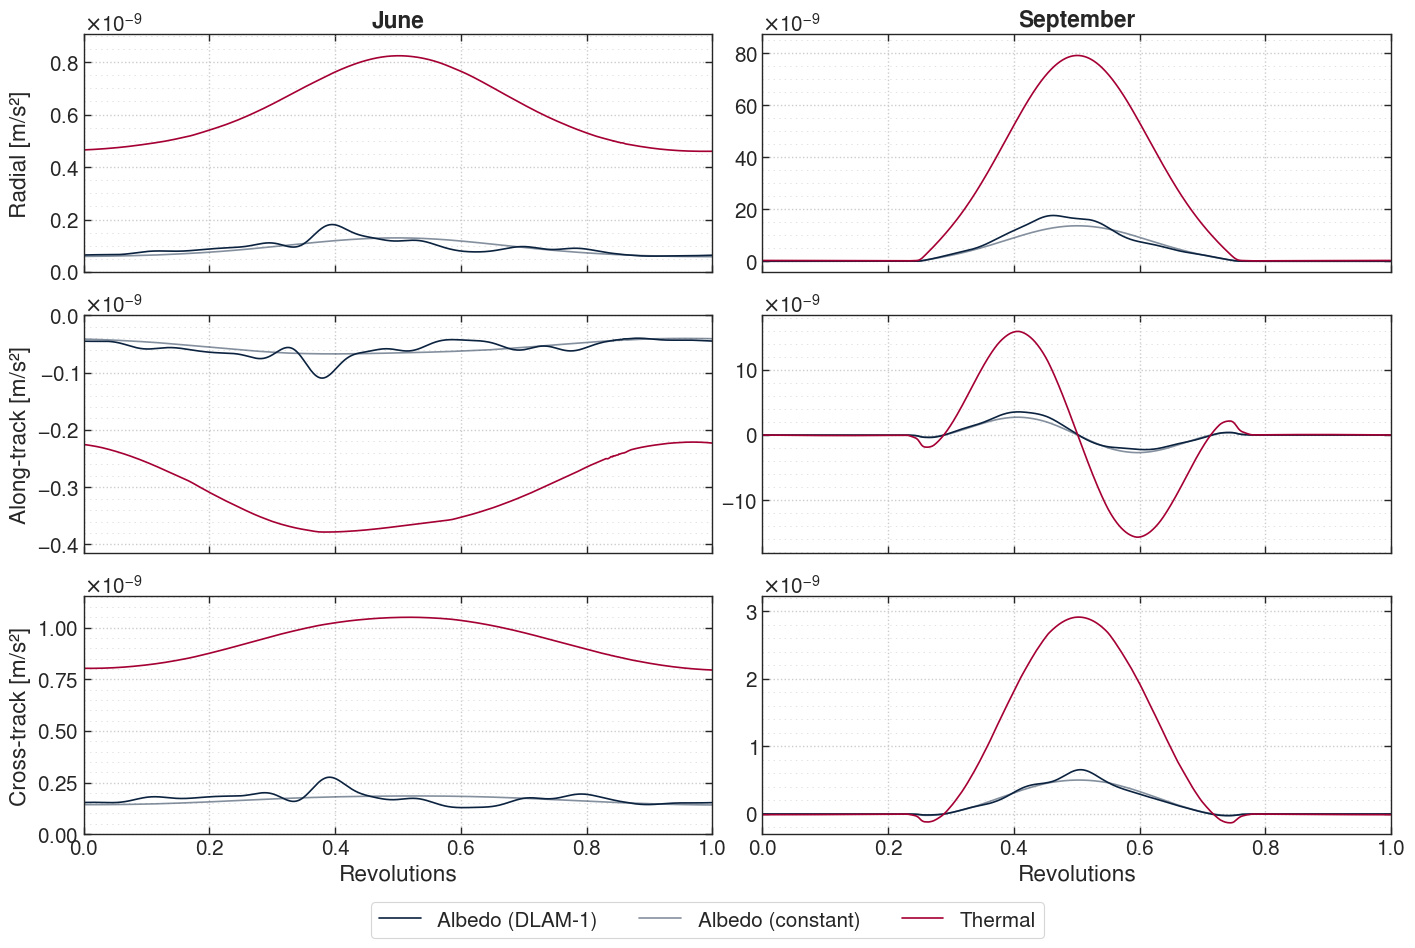

In [658]:
def plot_acc_albedovsthermal_single_orbit():
    fig, axs = plt.subplots(3, 2, figsize=(14, 8.8), sharex="all")

    albedo_color = "C0"
    thermal_color = "C1"

    for i, (start_date, start_index) in enumerate(zip(["2010 JUN 28", "2011 SEP 26"], [21.92, 21.55])):
        ax_radial, ax_along, ax_cross = axs[:, i]

        run_albedo_const = get_run(start_date, False, True, "Paneled", "constant", "NoThermal")
        run_albedo_const = trim_df_revolutions(run_albedo_const, start_index)

        run_albedo_dlam = get_run(start_date, False, True, "Paneled", "DLAM-1", "NoThermal")
        run_albedo_dlam = trim_df_revolutions(run_albedo_dlam, start_index)

        run_thermal = get_run(start_date, False, True, "Paneled", "NoAlbedo", "AngleBased")
        run_thermal = trim_df_revolutions(run_thermal, start_index)

        print(start_date,
            (run_albedo_dlam[f"acc_rp_moon_radial"]- run_albedo_const[f"acc_rp_moon_radial"]).abs().max(),
            rrmse(run_albedo_dlam[f"acc_rp_moon"], run_albedo_const[f"acc_rp_moon"], ignore_zeros=True)*100,
            rrmse(run_albedo_dlam[f"acc_rp_moon_radial"], run_albedo_const[f"acc_rp_moon_radial"], ignore_zeros=True)*100,
            rrmse(run_albedo_dlam[f"acc_rp_moon_along"], run_albedo_const[f"acc_rp_moon_along"], ignore_zeros=True)*100,
            rrmse(run_albedo_dlam[f"acc_rp_moon_cross"], run_albedo_const[f"acc_rp_moon_cross"], ignore_zeros=True)*100
        )
        print(run_thermal["acc_rp_moon"].min(), run_thermal["irr_moon"].min())

        ax_radial.plot(run_albedo_const.index, run_albedo_const[f"acc_rp_moon_radial"], alpha=0.5, color=albedo_color)
        ax_along.plot(run_albedo_const.index, run_albedo_const[f"acc_rp_moon_along"], alpha=0.5, color=albedo_color)
        ax_cross.plot(run_albedo_const.index, run_albedo_const[f"acc_rp_moon_cross"], alpha=0.5, color=albedo_color)

        ax_radial.plot(run_albedo_dlam.index, run_albedo_dlam[f"acc_rp_moon_radial"], alpha=1, color=albedo_color)
        ax_along.plot(run_albedo_dlam.index, run_albedo_dlam[f"acc_rp_moon_along"], alpha=1, color=albedo_color)
        ax_cross.plot(run_albedo_dlam.index, run_albedo_dlam[f"acc_rp_moon_cross"], alpha=1, color=albedo_color)

        ax_radial.plot(run_thermal.index, run_thermal[f"acc_rp_moon_radial"], color=thermal_color)
        ax_along.plot(run_thermal.index, run_thermal[f"acc_rp_moon_along"], color=thermal_color)
        ax_cross.plot(run_thermal.index, run_thermal[f"acc_rp_moon_cross"], color=thermal_color)
    
    fig.legend(
        [
            Line2D([0], [0], color=albedo_color),
            Line2D([0], [0], color=albedo_color, alpha=0.5),
            Line2D([0], [0], color=thermal_color),
        ],
        ["Albedo (DLAM-1)", "Albedo (constant)", "Thermal"],
        bbox_to_anchor=(0.5, -0.07), loc="lower center", ncol=3)

    axs[0, 0].set_title("June")
    axs[0, 1].set_title("September")

    for ax in axs[-1, :].flat:
        # Last row
        ax.set_xlim([0, 1])
        ax.set_xlabel("Revolutions")

    for ax, name in zip(axs[:, 0].flat, ["Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" [m/s²]")
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0] * 1.05), max(0, ax.get_ylim()[1] * 1.05)])
    
    format_plot(major_grid=True, minor_grid=True, x_minor_locator=NullLocator())
    save_plot(plots_folder, "acc_albedovsthermal")

plot_acc_albedovsthermal_single_orbit()

0.06746927921180243
146 694


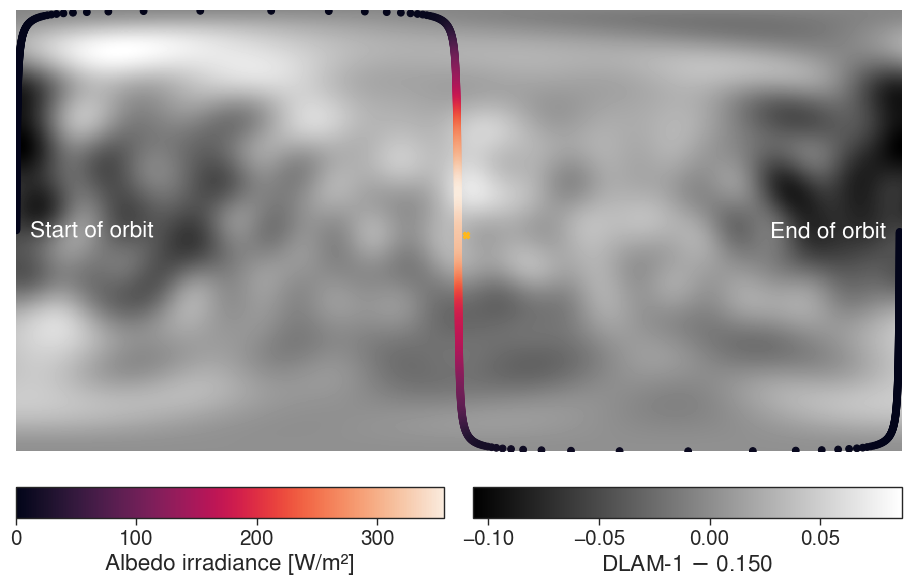

In [656]:
def plot_ground_track():
    # dist = tf_mosaic(imread("files/albedo.jpg")) - (0.19467246 / 1.3)
    dist = np.load("../private/dlam1.npy") - (0.19467246 / 1.3)

    run = get_run("2011 SEP 26", False, True, "Paneled", "DLAM-1", "NoThermal")
    run = trim_df_revolutions(run, 21.55)

    pos_sun = spice.spkpos("Sun", run.iloc[0]["t_et"], "MOON_ME", "NONE", "Moon")[0]
    _, polar_sun, azi_sun = cart2spher(*pos_sun)
    lat_sun = np.degrees(np.pi / 2 - polar_sun)
    lon_sun = np.degrees(azi_sun)

    # fig, ax = plt.subplots(
    #     figsize=(9, 4),
    #     constrained_layout=True,
    #     subplot_kw={"projection": ccrs.PlateCarree(164, globe=moon_globe)})
    # dist = np.load("../private/dlam1.npy")

    fig = plt.figure(figsize=(9, 6), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(2, 2, figure=fig, height_ratios=[8, 0.5]) 
    ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(164, globe=moon_globe))
    cax1 = fig.add_subplot(gs[1, 0])
    cax2 = fig.add_subplot(gs[1, 1])
    
    ax.imshow(dist, transform=ccrs.PlateCarree(globe=moon_globe), extent=(-180, 180, -90, 90), cmap="gray")
    ax.scatter(
        run["lon_moon"], run["lat_moon"],
        transform=ccrs.PlateCarree(globe=moon_globe),
        c=run["irr_moon"], cmap="rocket"
    )
    # ax.gridlines(draw_labels=["bottom", "left"], crs=ccrs.PlateCarree(globe=moon_globe))
    ax.set_axis_off()

    ax.scatter(lon_sun, lat_sun, marker="X", c="C4", transform=ccrs.PlateCarree(globe=moon_globe))
    print(int((90 - (lat_sun+18))*2), int((180 + lon_sun)*2))

    ax.annotate(
        "Start of orbit",
        run.iloc[0][["lon_moon", "lat_moon"]],
        xytext=(10, 0),
        va="center",
        ha="left",
        color="white",
        textcoords="offset points",
        transform=ccrs.PlateCarree(globe=moon_globe)
    )

    ax.annotate(
        "End of orbit",
        run.iloc[-1][["lon_moon", "lat_moon"]],
        xytext=(-10, 0),
        va="center",
        ha="right",
        color="white",
        textcoords="offset points",
        transform=ccrs.PlateCarree(globe=moon_globe)
    )

    cb1 = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(
            vmin=run["irr_moon"].min(), vmax=run["irr_moon"].max()
            ), cmap="rocket"),
        cax=cax1, orientation='horizontal', label="Albedo irradiance [W/m²]")
    cb1.ax.tick_params(direction="out", which="both")


    cb2 = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(
            vmin=dist.min(), vmax=dist.max()
            ), cmap="gray"),
        cax=cax2, orientation='horizontal', label="DLAM-1 $-$ 0.150")
    cb2.ax.tick_params(direction="out", which="both")

    save_plot(plots_folder, "groundtrack")
    
plot_ground_track()

## Small-scale investigations

Paragraph about secular variations in sun RP for june arc due to eccentrity:

(0.0048965889258934, 0.0079950705798913)

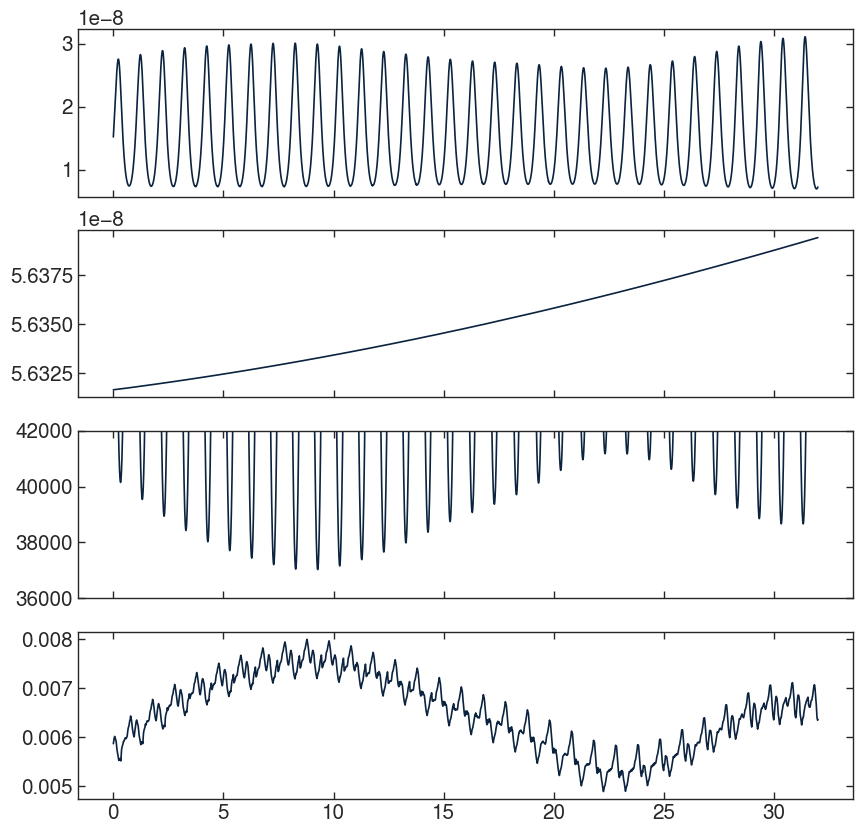

In [ ]:
x = get_run("2010 JUN", True, True, "Cannonball", "constant", "AngleBased")
x.index = get_revolutions_index(x)
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
axs[0].plot(x.index, x["irr_moon"] / (x["h"]**2))
axs[1].plot(x.index, x["acc_rp_sun"])
axs[2].plot(x.index, x["h"])
axs[2].set_ylim([36e3, 42e3])
# axs[3].plot(x.index, x["angle_subsolar"])
axs[3].plot(x.index, x["kepler_e"])
x["kepler_e"].min(), x["kepler_e"].max()
# axs[2].set_xlim([2, 4])

Total magnitudes for solar and lunar:

(5.06026949963834e-08, 5.85081010581147e-08)

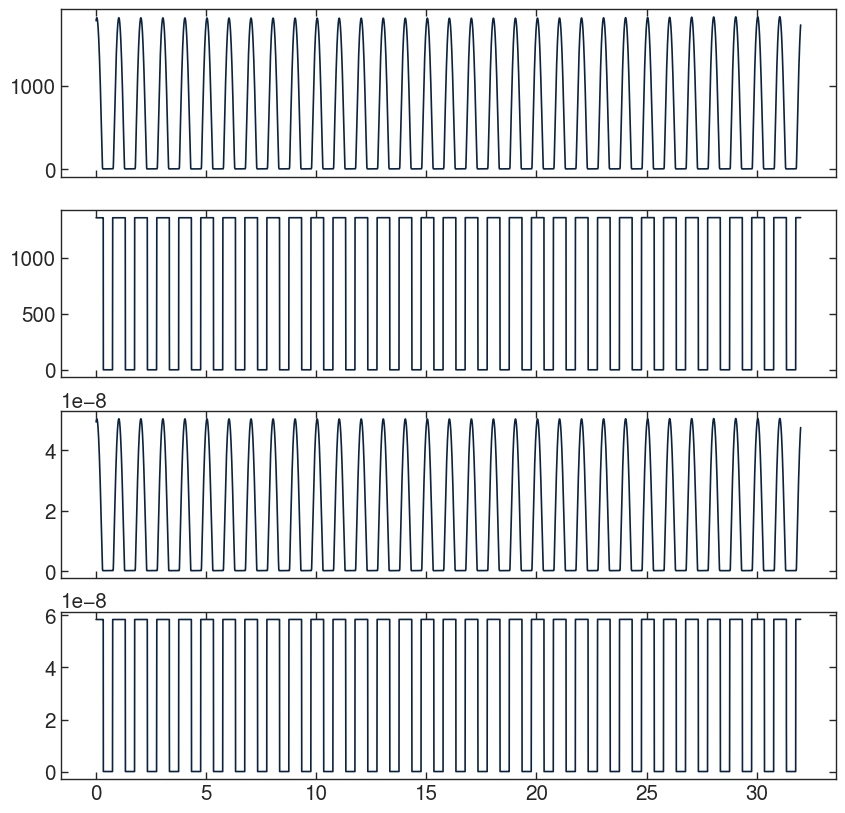

In [ ]:
x = get_run("2011 SEP", True, True, "Cannonball", "constant", "AngleBased")
x.index = get_revolutions_index(x)
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
axs[0].plot(x.index, x["irr_moon"])
axs[1].plot(x.index, x["irr_sun"])
axs[2].plot(x.index, x["acc_rp_moon"])
axs[3].plot(x.index, x["acc_rp_sun"])
# x["irr_moon"].max(), x["irr_sun"].max()
x["acc_rp_moon"].max(), x["acc_rp_sun"].max()

Subsolar angle of peak along-track lunar RP in september arc:

33.63648363789538

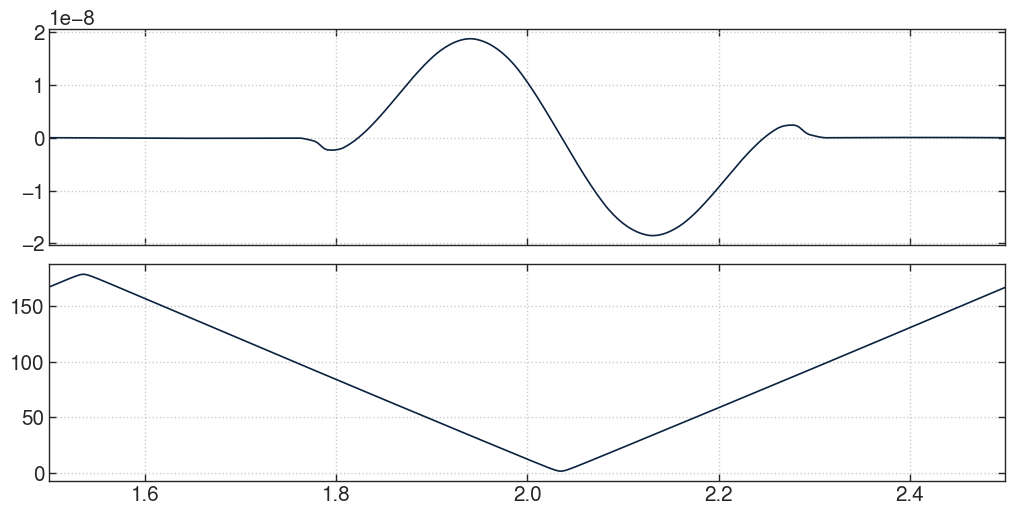

In [ ]:
x = get_run("2011 SEP", True, True, "Paneled", "constant", "AngleBased")
x.index = get_revolutions_index(x)
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axs[0].plot(x.index, x["acc_rp_moon_along"])
axs[1].plot(x.index, x["angle_subsolar"])
axs[1].set_xlim([1.5, 2.5])
format_plot(major_grid=True)
x["angle_subsolar"].loc[x["acc_rp_moon_along"].loc[1.5:2.5].idxmax()]

Selenographic location of maximum difference between DLAM and constant:

lat_moon     15.660626
lon_moon    163.603305
Name: 0.4526888538272118, dtype: float64

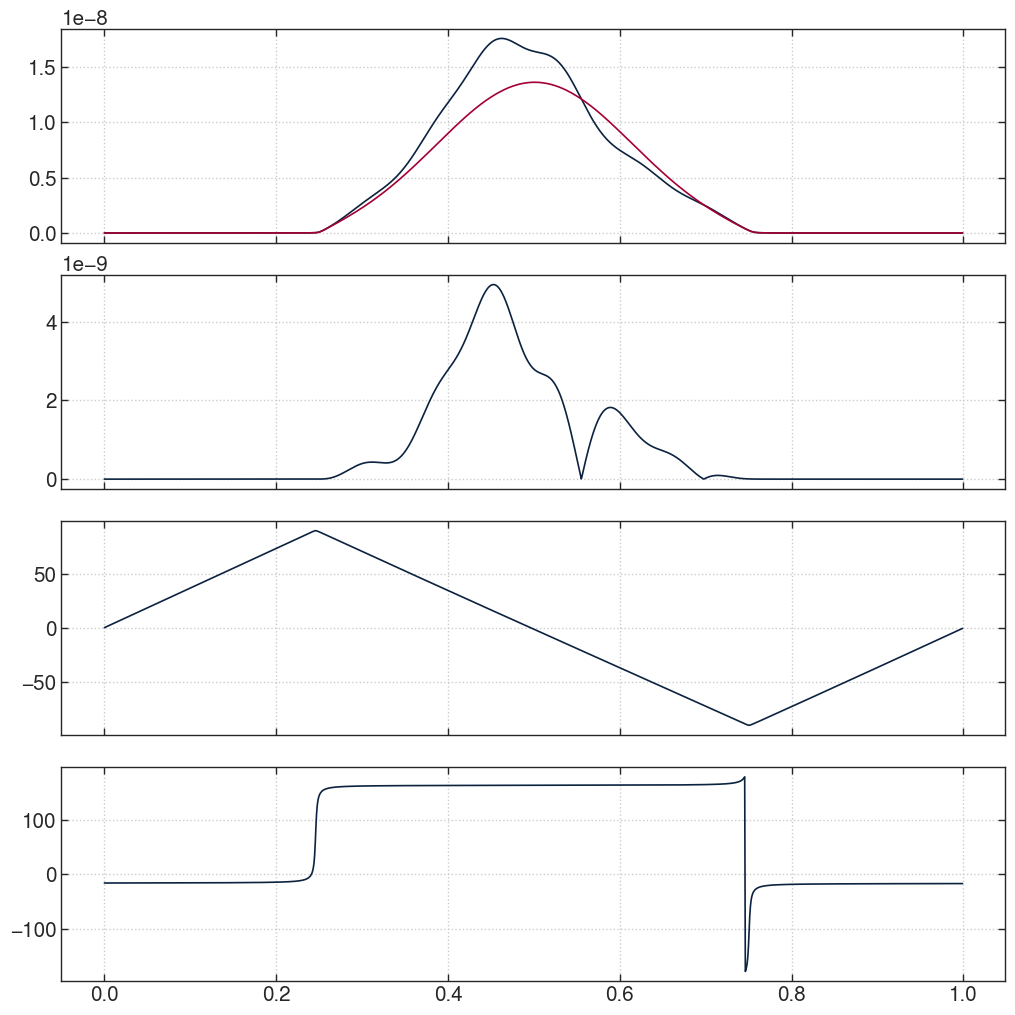

In [580]:
x = get_run("2011 SEP", True, True, "Paneled", "DLAM-1", "NoThermal")
x_const = get_run("2011 SEP", True, True, "Paneled", "constant", "NoThermal")
x = trim_df_revolutions(x, 21.55)
x_const = trim_df_revolutions(x_const, 21.55)
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
axs[0].plot(x.index, x["acc_rp_moon_radial"])
axs[0].plot(x_const.index, x_const["acc_rp_moon_radial"])
axs[1].plot(x.index, (x["acc_rp_moon_radial"] - x_const["acc_rp_moon_radial"]).abs())
axs[2].plot(x.index, x["lat_moon"])
axs[3].plot(x.index, x["lon_moon"])
format_plot(major_grid=True)
idxmax = (x["acc_rp_moon_radial"] - x_const["acc_rp_moon_radial"]).abs().idxmax()
x.loc[idxmax][["lat_moon", "lon_moon"]]

# Orbital elements

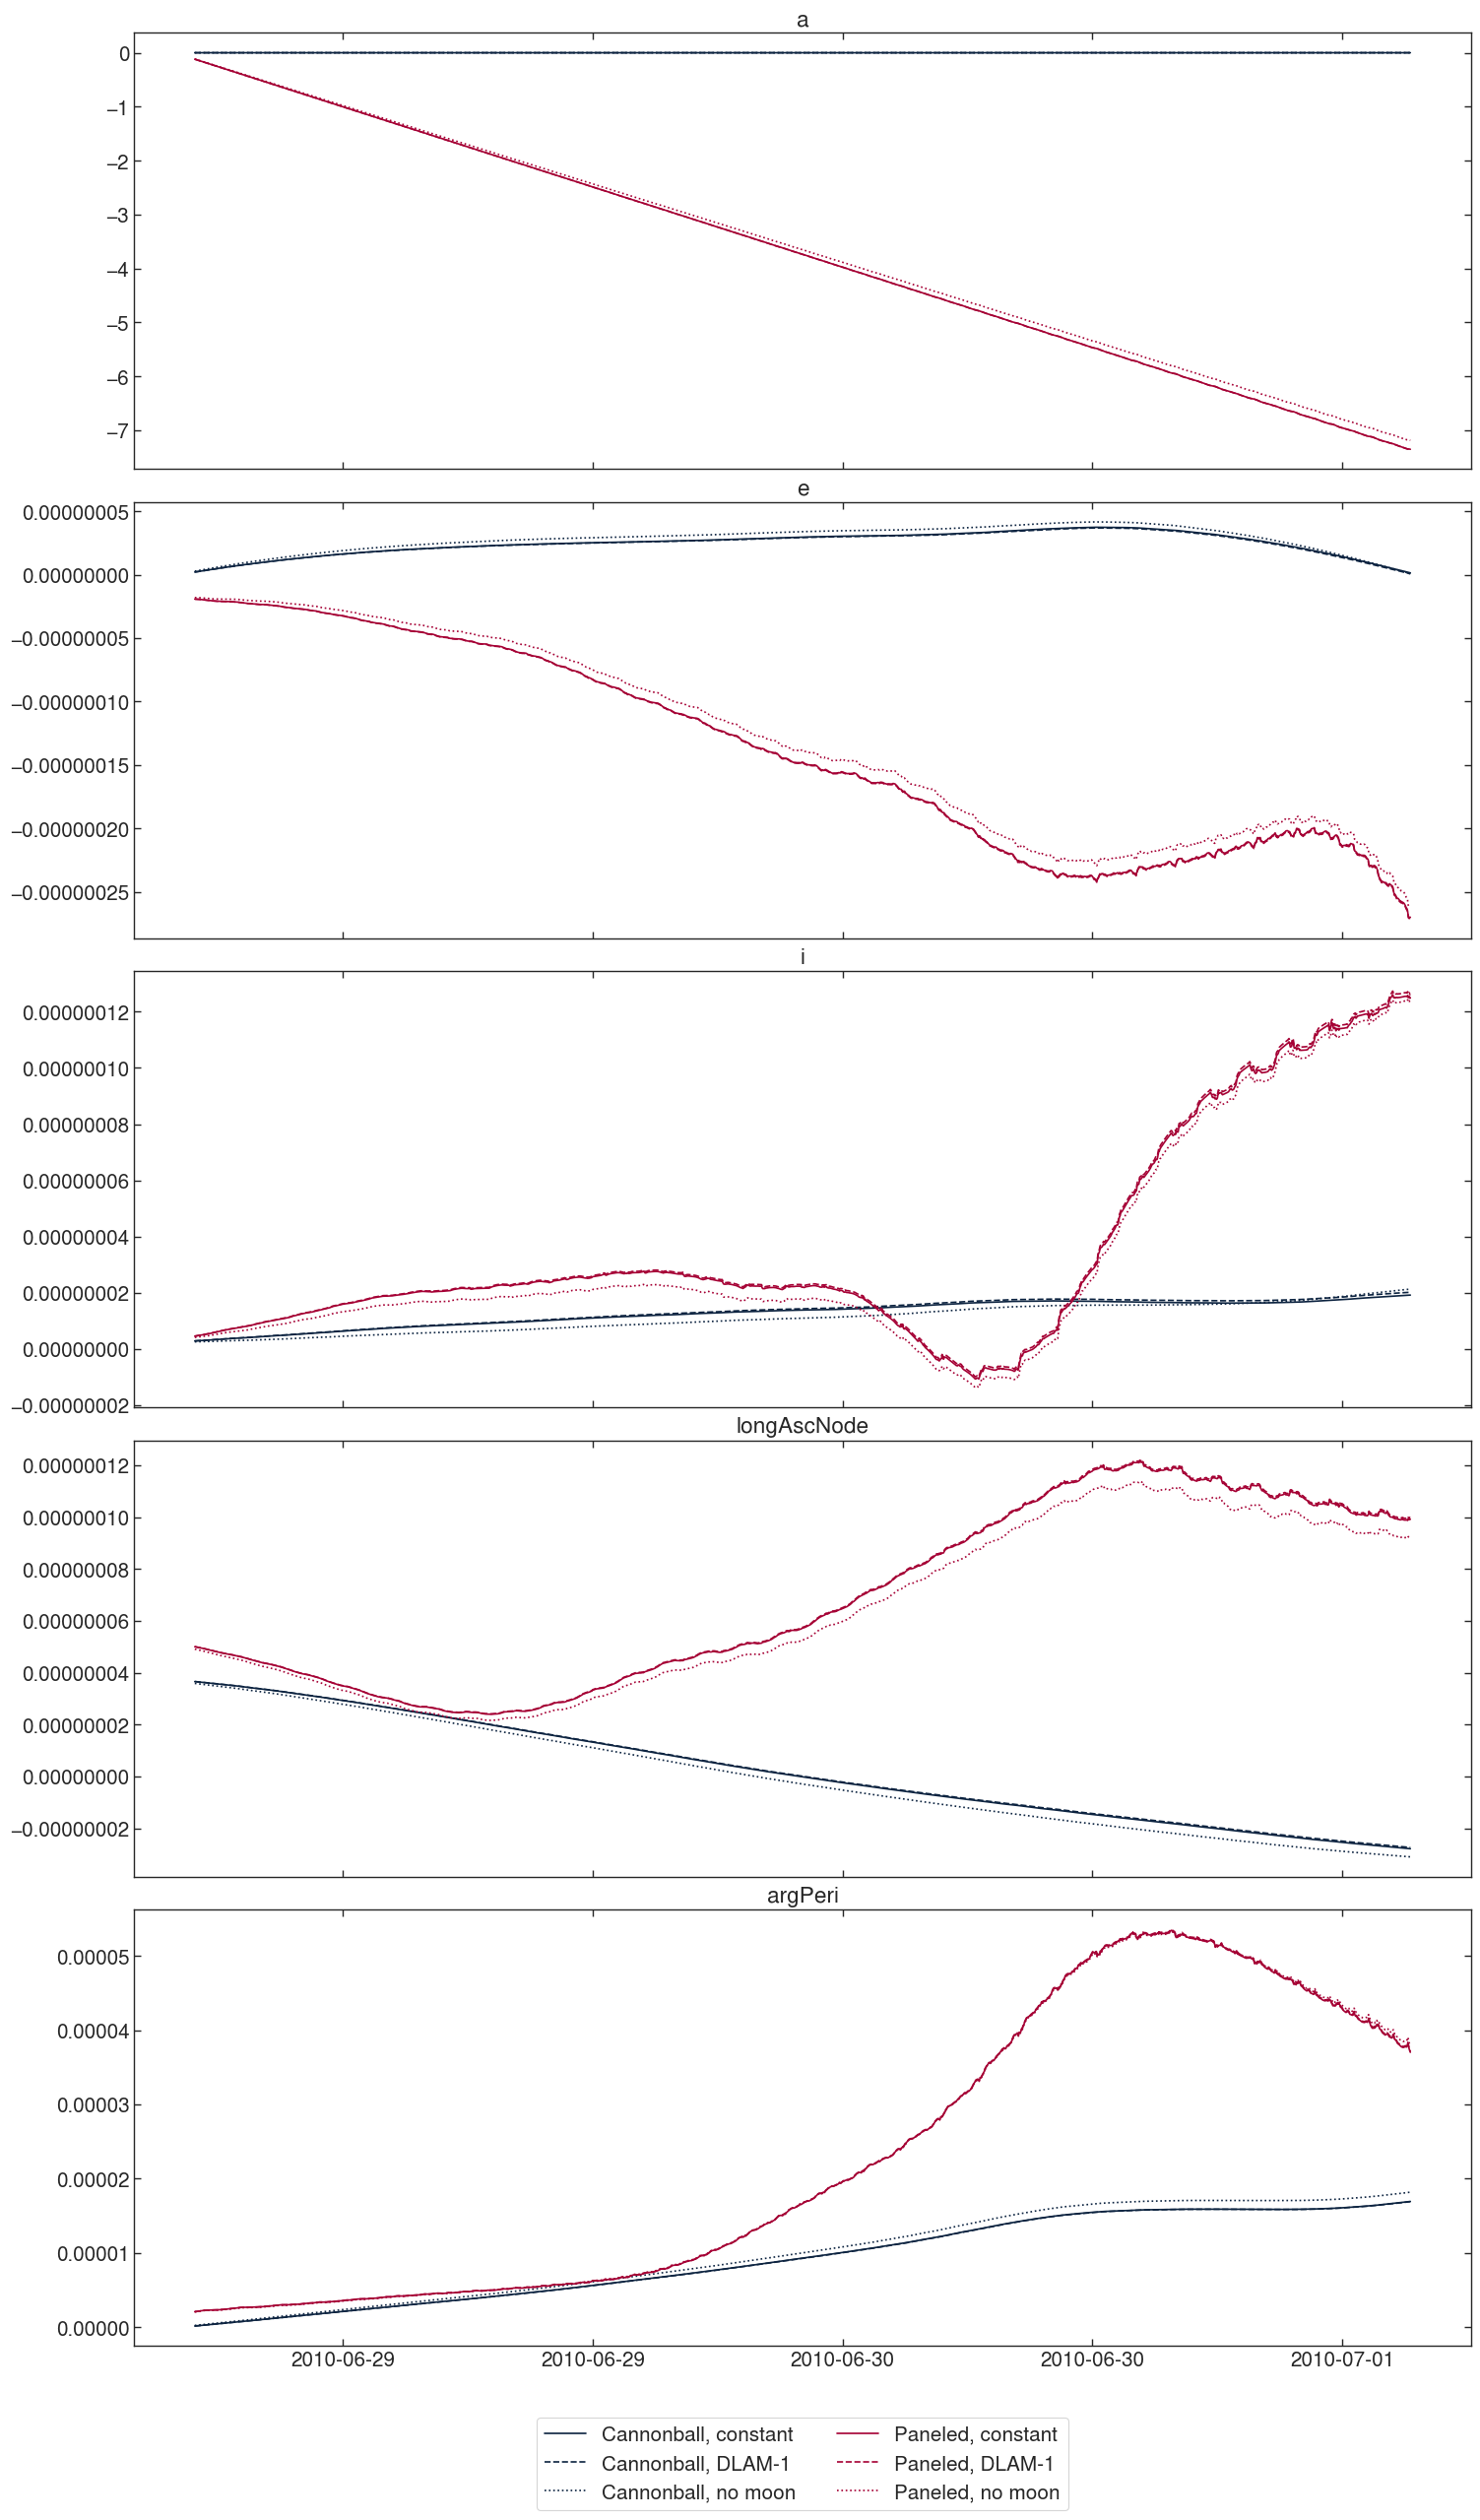

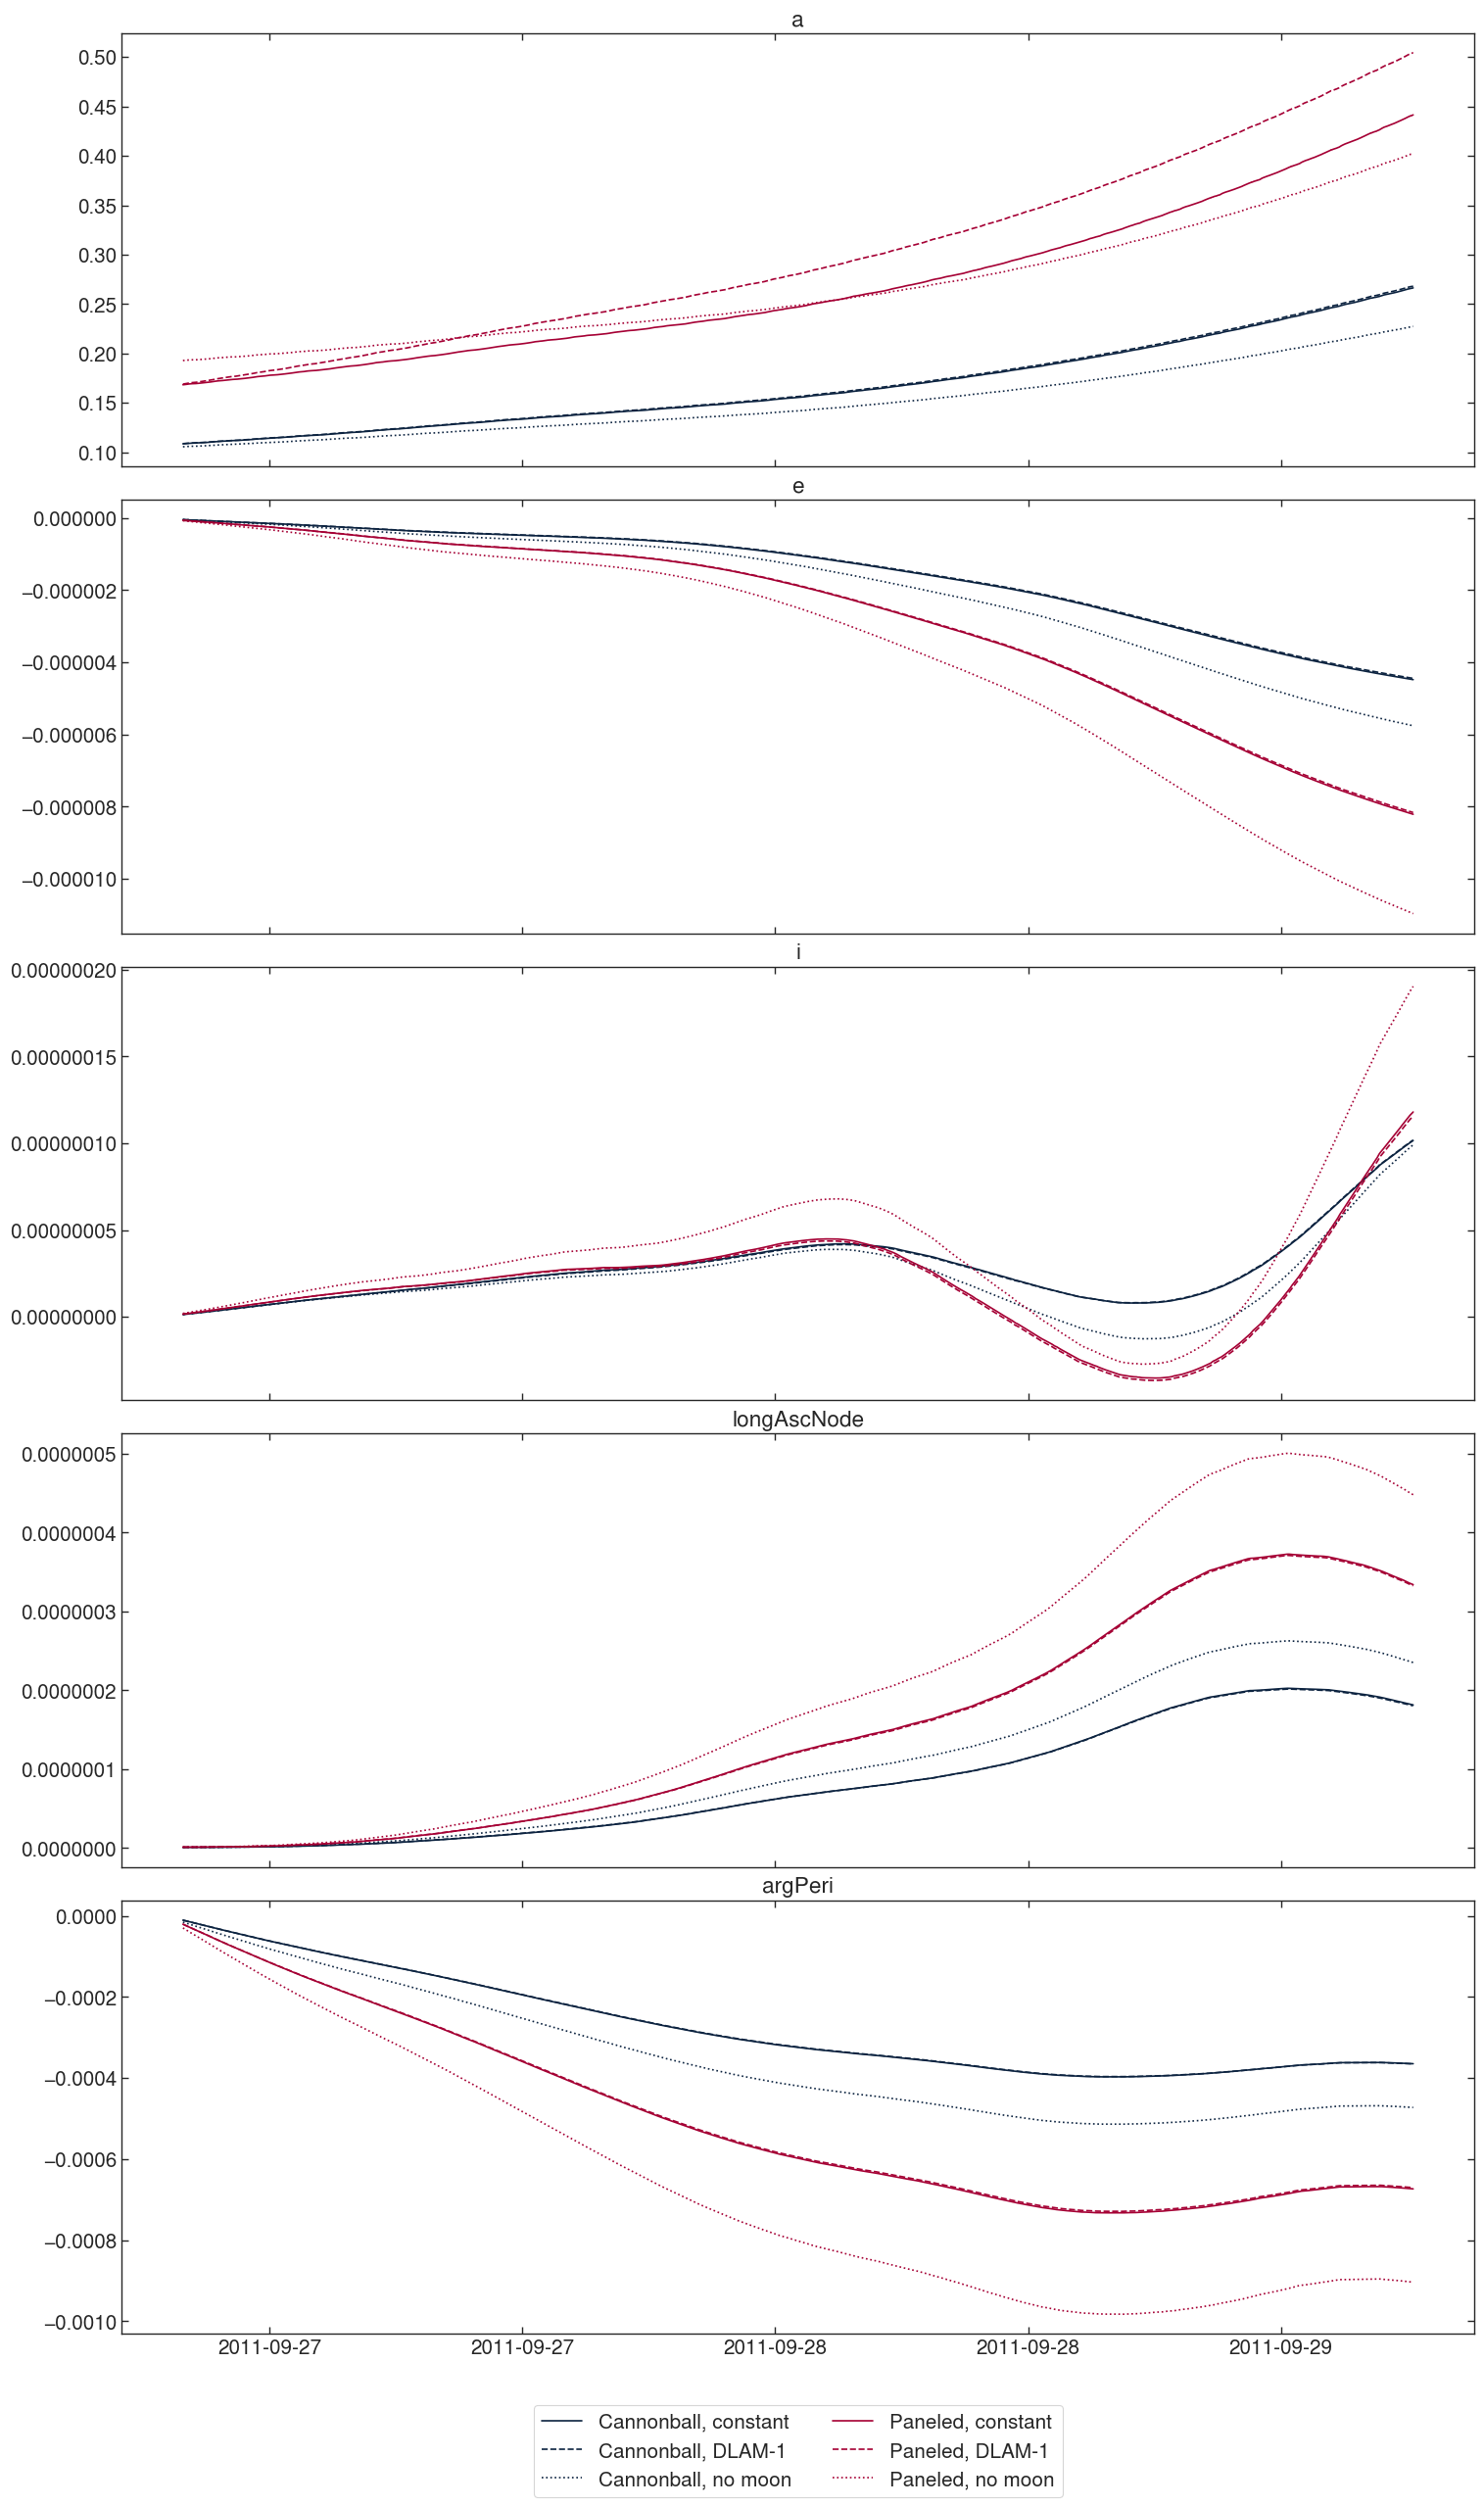

In [ ]:
def plot_kepler_elements(start_date, mean=False, percent=False):
    fig, axs = plt.subplots(5, figsize=(15, 5*5), sharex="all")

    names = ["a", "e", "i", "longAscNode", "argPeri"]

    df_baseline = get_baseline(start_date)

    for i, (target_type, albedo_distribution_moon) in enumerate(itertools.product(["Cannonball", "Paneled"], ["constant", "DLAM-1", None])):
        if albedo_distribution_moon is None:
            run = get_run(start_date, True, False, target_type, "", True)
        else:
            run = get_run(start_date, True, True, target_type, albedo_distribution_moon, True)

        color = f"C{int(target_type == 'Paneled')}"
        ls = {
            "constant": "-",
            "DLAM-1": "--",
            None: ":"
        }[albedo_distribution_moon]

        for ax, name in zip(axs, names):
            y = run[f"kepler_{name}"] - df_baseline[f"kepler_{name}"]
            if percent:
                y *= 100 / df_baseline[f"kepler_{name}"]
                y = y[y < 100]
            else:
                y = y[y / df_baseline[f"kepler_{name}"] < 1]
            if mean:
                y = y.rolling(orbit_steps).mean()
            ax.plot(y.index, y, label=f"{target_type}, {albedo_distribution_moon or 'no moon'}", color=color, ls=ls)
    
    axs[-1].legend(bbox_to_anchor =(0.5,-0.4), loc="lower center", ncol=2)
    for ax, name in zip(axs, names):
        ax.set_title(name)
        ax.ticklabel_format(axis="y", style="plain")

    # axs[-1].set_xlim([dt(2010, 9, 27, 6), dt(2010, 9, 27, 6) + timedelta(minutes=3*113)])
    
    format_plot()

# plot_kepler_elements("2010 JUN 28", mean=False, percent=False)
plot_kepler_elements("2010 JUN 28", mean=True, percent=False)
plot_kepler_elements("2011 SEP 26", mean=True, percent=False)

June (beta = 90):
* Largest change in inclination

September (beta = 0):
* Largest changes in eccentricity and semi major axis